In [1]:
library(tidyverse)  
library(data.table) 
library(lubridate)  
library(gridExtra)  
library(plotly)     
library(scales)     
library(fBasics)    
library(reshape)    
library(ggrepel)    
library(knitr)      
library(forecast)  
library(MLmetrics)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

Th

In [2]:
df<-read.csv('so2_no2_o3.csv')

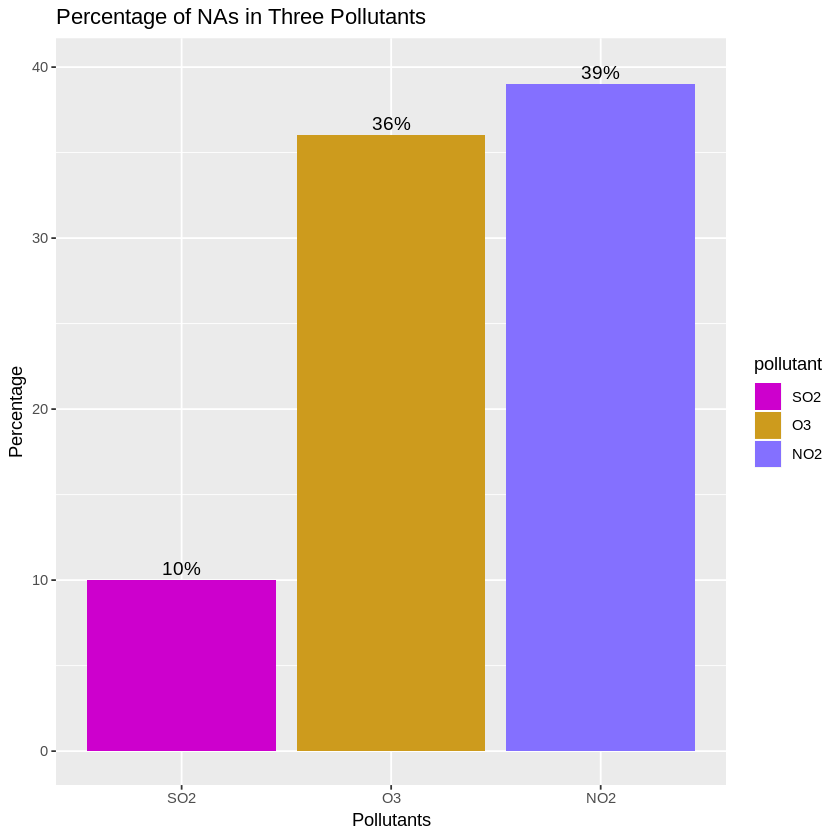

In [3]:
temp<-df[,c('SO2','O3','NO2')]
na_df<-data.frame(percent=round(colSums(is.na(temp))/nrow(temp)*100))
na_df$poll <- rownames(na_df)
na_df$pollutant<-factor(na_df$poll, as.character(na_df$poll))

ggplot(na_df, aes(pollutant, percent,fill=pollutant))+
geom_bar(stat="identity") +scale_fill_manual(values = c("magenta3","goldenrod3","lightslateblue"))+
geom_text(data=na_df, aes(label=paste0(percent,"%"),
                               y=percent+0.7), size=4)+
 labs(x = "Pollutants", y = "Percentage", 
         title = "Percentage of NAs in Three Pollutants")

In [4]:
summary(df[,c("SO2","O3","NO2")])

      SO2               O3              NO2        
 Min.   : -1.5    Min.   : -1.0    Min.   : -0.8   
 1st Qu.:  1.0    1st Qu.:  8.0    1st Qu.: 14.0   
 Median :  3.0    Median : 21.0    Median : 24.0   
 Mean   :  5.8    Mean   : 22.4    Mean   : 26.3   
 3rd Qu.:  8.0    3rd Qu.: 33.0    3rd Qu.: 36.0   
 Max.   :369.0    Max.   :185.0    Max.   :258.0   
 NA's   :230419   NA's   :836722   NA's   :903412  

In [5]:
colnames(df)

[1] "X"                    "state_code"           "county_code"         
 [4] "site_num"             "date_local"           "time_local"          
 [7] "date_gmt"             "time_gmt"             "SO2"                 
[10] "SO2.mdl"              "SO2.Uncertainty"      "state_name"          
[13] "county_name"          "datetime_gmt"         "datetime_local"      
[16] "O3"                   "O3.mdl"               "O3.Uncertainty"      
[19] "NO2"                  "NO2.mdl"              "NO2.Uncertainty"     
[22] "Units.of.Measurement"

## Before Aggregation

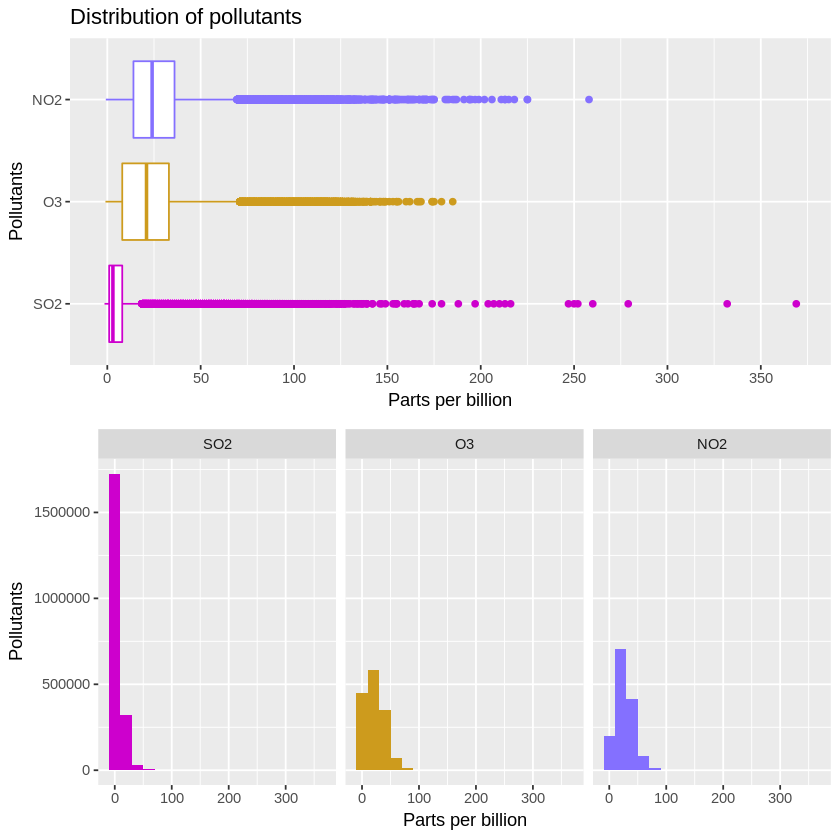

In [6]:
melt_nyc <- melt(df,id.vars='datetime_local', measure.vars=c('SO2','O3','NO2'))
three_box_obs<-ggplot(na.omit(melt_nyc),aes(x=variable, y=value, color=variable)) +
      geom_boxplot()+ coord_flip()+
    scale_colour_manual(values=c("magenta3","goldenrod3","lightslateblue"))+
        theme(legend.position="none")+scale_y_continuous(breaks = seq(0, 700, by = 50))+
       labs(title="Distribution of pollutants",x='Pollutants',y='Parts per billion')

three_hist_obs<-ggplot(na.omit(melt_nyc),aes(x = value,fill=variable)) + 
    facet_wrap(~variable, nrow = 1) + 
    geom_histogram(binwidth=20)+
    scale_fill_manual(values=c("magenta3","goldenrod3","lightslateblue"))+
  theme(legend.position="none")+
    labs(x='Parts per billion',y='Pollutants')
grid.arrange(three_box_obs,three_hist_obs,nrow=2)

## After Aggregation (i.e. taking the monthly average of the maximum value of each day)

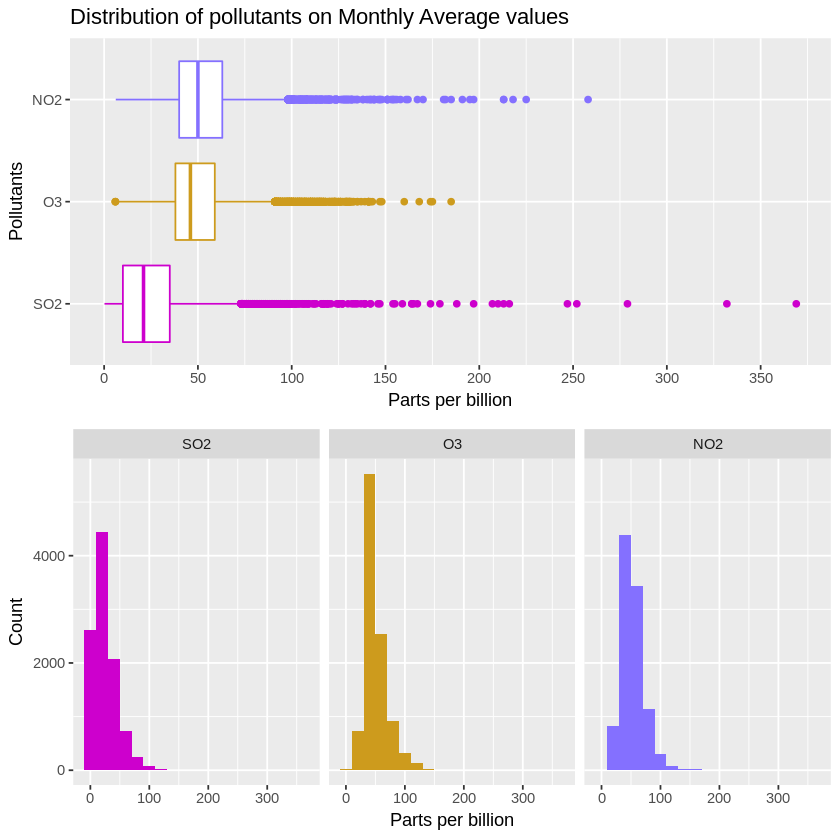

In [7]:
max_pollutants_per_day<-df%>%
     as.data.frame %>%
    select('datetime_local','SO2','O3','NO2')%>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(SO2=max(SO2,na.rm=TRUE),
                   O3=max(O3,na.rm=TRUE),
                  NO2=max(NO2,na.rm=TRUE)
                  )
max_pollutants_df<-as.data.frame(max_pollutants_per_day)
melt_nyc_max_pollutants <- melt(max_pollutants_df,id.vars='date_ymd', measure.vars=c('SO2','O3','NO2'))
three_box_daily_max<-ggplot(melt_nyc_max_pollutants,aes(x=variable, y=value, color=variable)) +
      geom_boxplot()+ coord_flip()+
    scale_colour_manual(values=c("magenta3","goldenrod3","lightslateblue"))+
        theme(legend.position="none")+scale_y_continuous(breaks = seq(0, 700, by = 50))+
       labs(title="Distribution of pollutants on Monthly Average values",x='Pollutants',y='Parts per billion')

three_hist_daily_max<-ggplot(melt_nyc_max_pollutants,aes(x = value,fill=variable)) + 
    facet_wrap(~variable, nrow = 1) + 
    geom_histogram(binwidth=20)+
    scale_fill_manual(values=c("magenta3","goldenrod3","lightslateblue"))+
  theme(legend.position="none")+
    labs(x='Parts per billion',y='Count')

grid.arrange(three_box_daily_max,three_hist_daily_max,nrow=2)

In [8]:
plot_pollutant<-function(pol,title,colour){
pol<-enquo(pol)
date_df<-df%>%
            mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_emission=max(!!pol,na.rm=TRUE))

plot1<-ggplot(data=date_df,aes(x=date_ymd,y=max_emission))+geom_line(color=colour)+
scale_x_date(breaks = seq(as.Date("1990-01-01"), as.Date("2017-12-31"), by="6 months"),labels = date_format("%b-%y"))+
xlab('Date')+ylab('Parts per billion')+ggtitle(paste('Daily Maximum Emission of',title))+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")

month_df<-date_df%>%
    mutate(y_m_d=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m_d)%>%
   summarise(avg_emission=mean(max_emission,na.rm=TRUE))


plot2<-ggplot(data=month_df,aes(x=as.Date(y_m_d, format = "%Y - %m - %d"),y=avg_emission))+geom_line(color=colour)+
scale_x_date(breaks = seq(as.Date("1990-01-01"), as.Date("2017-12-31"), by="6 months"), date_labels = "%b-%y")+
xlab('Date')+ylab('Parts per billion')+ggtitle(paste('Monthly Average Emission of',title))+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")
grid.arrange(plot1,plot2,nrow=2)
}

Warning message:
“Removed 8 rows containing missing values (geom_path).”

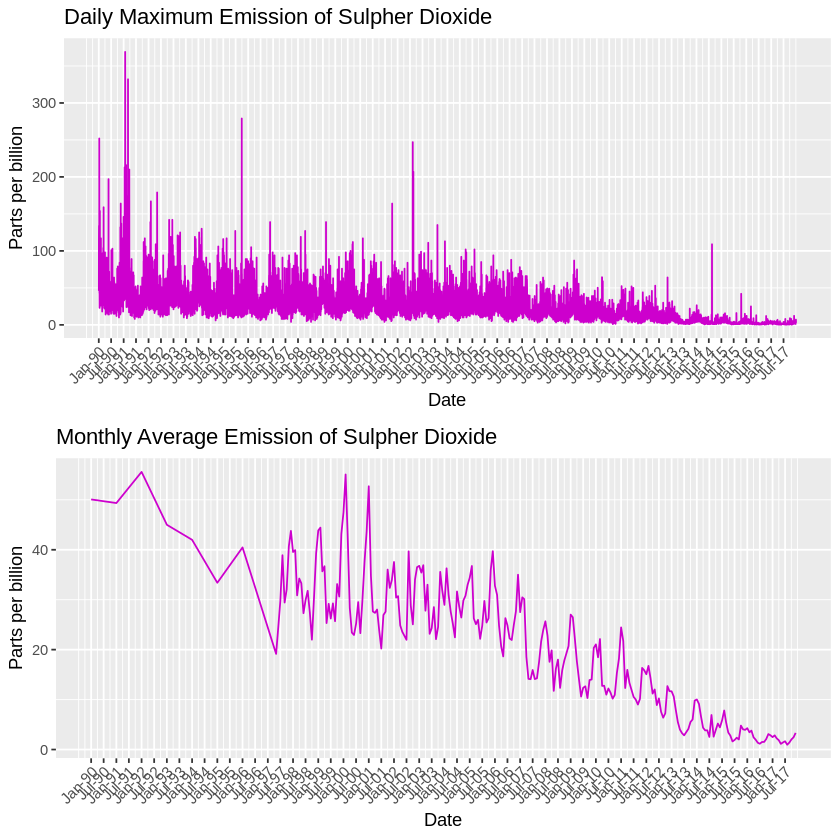

In [9]:
plot_pollutant(SO2,"Sulpher Dioxide","magenta3")

Warning message:
“Removed 8 rows containing missing values (geom_path).”

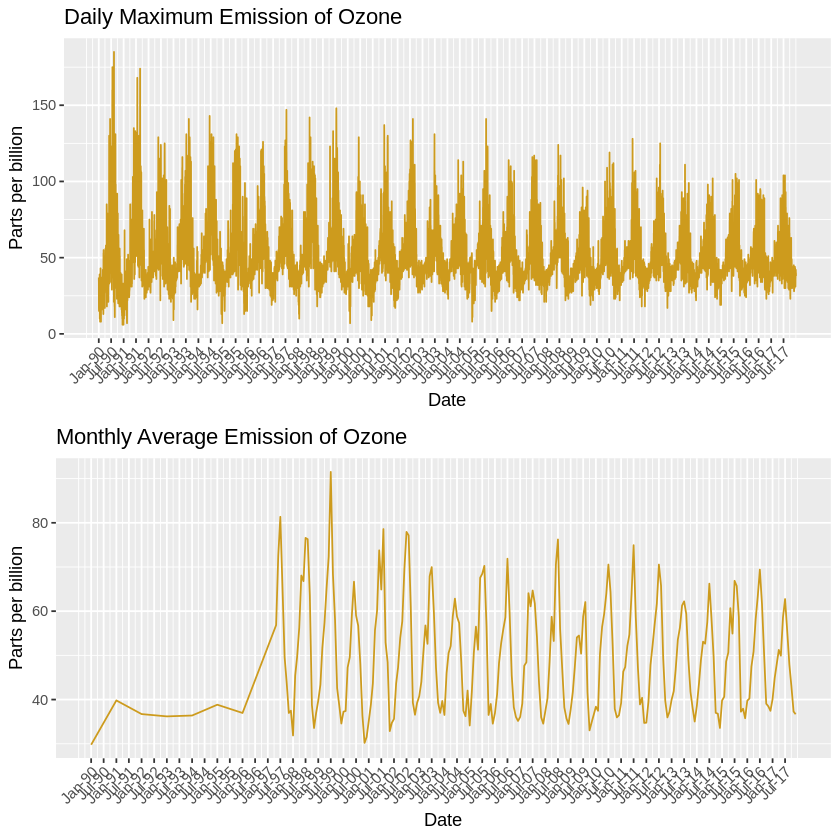

In [10]:
plot_pollutant(O3,"Ozone","goldenrod3")

Warning message:
“Removed 8 rows containing missing values (geom_path).”

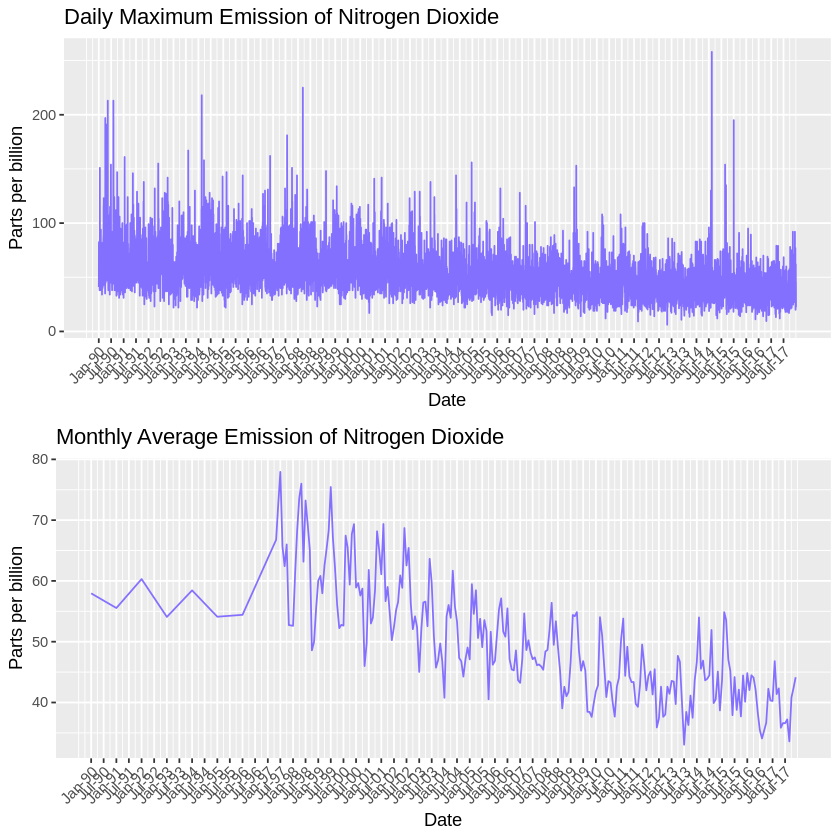

In [11]:
plot_pollutant(NO2,"Nitrogen Dioxide","lightslateblue")

Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 8 rows containing missing values (geom_path).”

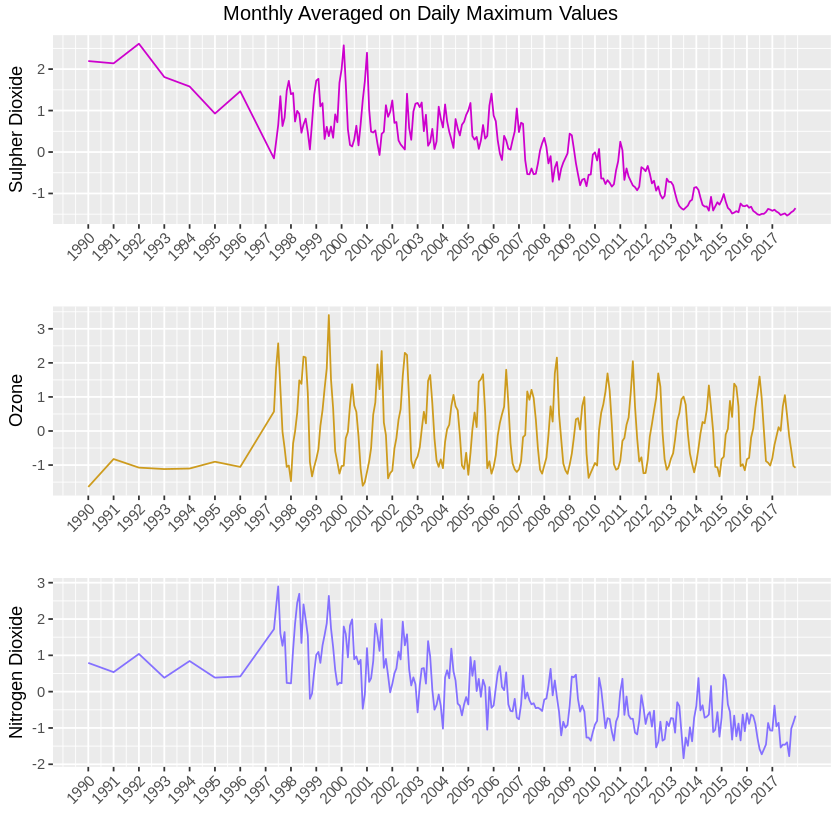

In [12]:
plot_scale_monthly <- function(pol,title,colour) {
    pol <- enquo(pol)
    
daily_max<-df%>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_emission=max(!!pol,na.rm=TRUE))
 month_avg<-daily_max%>%
     mutate(y_m_d=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m_d)%>%
   summarise(avg_emission=mean(max_emission,na.rm=TRUE))

ggplot(data=month_avg,aes(x=as.Date(y_m_d,format="%Y - %m - %d"),y=scale(avg_emission)))+ geom_line(color=colour)+
    scale_x_date(breaks = seq(as.Date("1990-01-01"), as.Date("2017-12-31"), by="12 months"), date_labels = "%Y")+
xlab('')+ylab(title)+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")   
}


p1<-plot_scale_monthly(SO2,"Sulpher Dioxide","magenta3")
p2<-plot_scale_monthly(O3,"Ozone","goldenrod3")
p3<-plot_scale_monthly(NO2,"Nitrogen Dioxide","lightslateblue")
grid.arrange(p1,p2,p3,nrow=3,top = "Monthly Averaged on Daily Maximum Values")

In [14]:
df$month<-month(as.POSIXct(df$datetime_local))
df$hour<-hour(as.POSIXct(df$datetime_local))

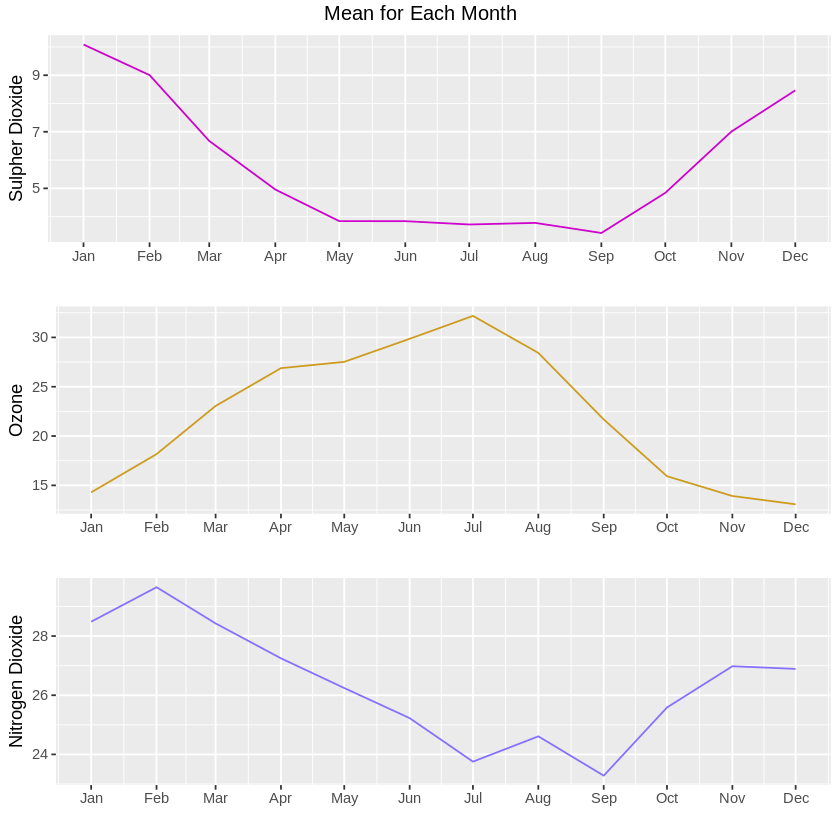

In [15]:
pol_each_month<-function(pol,title,colour){
    pol=enquo(pol)
each_month_pol_df<-df%>%
    select('month','datetime_local','SO2','O3','NO2')%>%
   mutate(month=as.Date(paste0("1990-",df$month,"-01"),"%Y-%m-%d"))%>%
  group_by(month)%>%
  summarise(count=mean(!!pol,na.rm=TRUE))
ggplot(each_month_pol_df,aes(month,count))+geom_line(color=colour)+
scale_x_date(breaks = seq(as.Date("1990-01-01"), as.Date("1990-12-01"), by="1 month"), date_labels = "%b")+
    xlab('')+ylab(title)
}

m1<-pol_each_month(SO2,"Sulpher Dioxide","magenta3")
m2<-pol_each_month(O3,"Ozone","goldenrod3")
m3<-pol_each_month(NO2,"Nitrogen Dioxide","lightslateblue")
grid.arrange(m1,m2,m3,nrow=3,top = "Mean for Each Month")

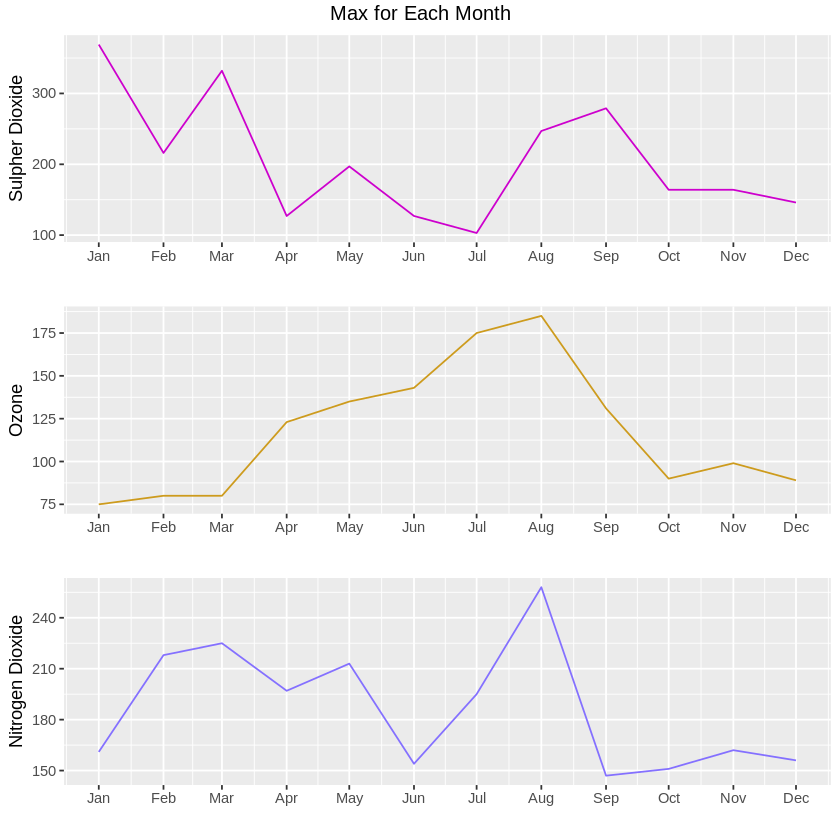

In [16]:
pol_each_month<-function(pol,title,colour){
    pol=enquo(pol)
each_month_pol_df<-df%>%
    select('month','datetime_local','SO2','O3','NO2')%>%
   mutate(month=as.Date(paste0("1990-",df$month,"-01"),"%Y-%m-%d"))%>%
  group_by(month)%>%
  summarise(count=max(!!pol,na.rm=TRUE))
ggplot(each_month_pol_df,aes(month,count))+geom_line(color=colour)+
scale_x_date(breaks = seq(as.Date("1990-01-01"), as.Date("1990-12-01"), by="1 month"), date_labels = "%b")+
    xlab('')+ylab(title)
}

m1<-pol_each_month(SO2,"Sulpher Dioxide","magenta3")
m2<-pol_each_month(O3,"Ozone","goldenrod3")
m3<-pol_each_month(NO2,"Nitrogen Dioxide","lightslateblue")
grid.arrange(m1,m2,m3,nrow=3,top = "Max for Each Month")

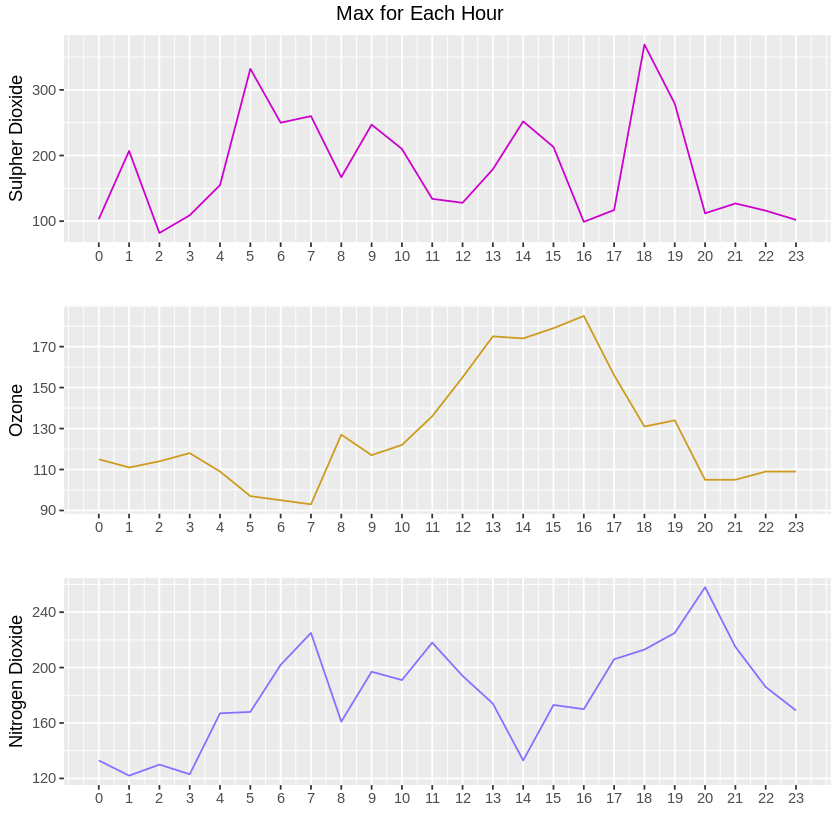

In [17]:
pol_each_hour<-function(pol,title,colour){
    pol=enquo(pol)

each_hour_pol_df<-df%>%
    select('hour','datetime_local','SO2','O3','NO2')%>%
  group_by(hour)%>%
  summarise(count=max(!!pol,na.rm=TRUE))
    
 ggplot(each_hour_pol_df,aes(as.numeric(hour),count))+geom_line(color=colour)+
    scale_x_continuous(breaks=seq(0,23,1), limits=c(0,23)) +
    xlab('')+ylab(title)
}

h1<-pol_each_hour(SO2,"Sulpher Dioxide","magenta3")
h2<-pol_each_hour(O3,"Ozone","goldenrod3")
h3<-pol_each_hour(NO2,"Nitrogen Dioxide","lightslateblue")
grid.arrange(h1,h2,h3,nrow=3,top = "Max for Each Hour")

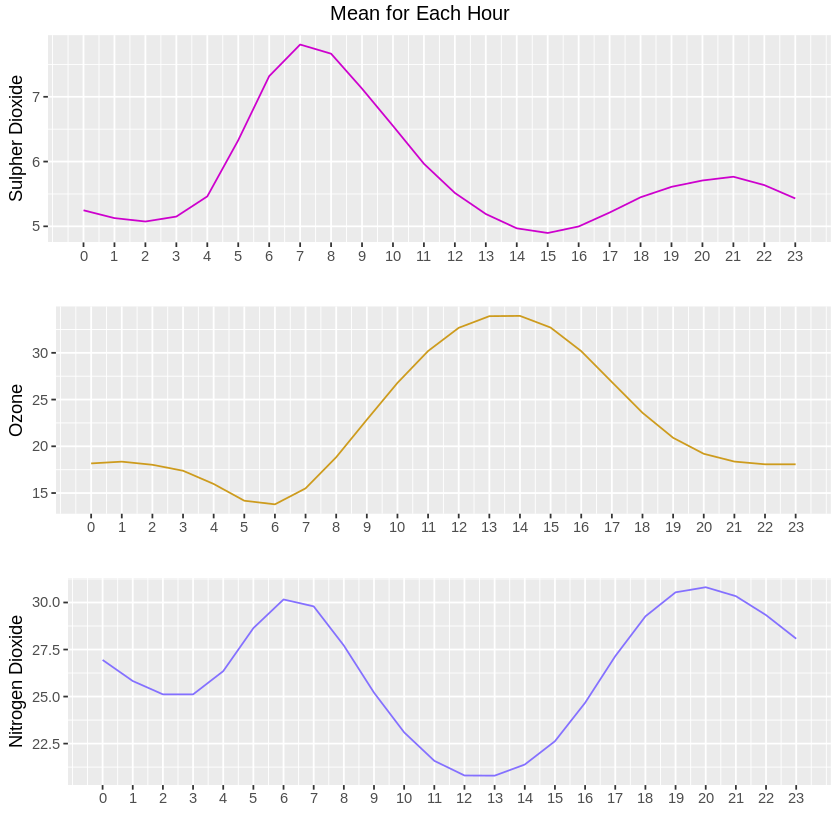

In [18]:
pol_each_hour<-function(pol,title,colour){
    pol=enquo(pol)

each_hour_pol_df<-df%>%
    select('hour','datetime_local','SO2','O3','NO2')%>%
  group_by(hour)%>%
  summarise(count=mean(!!pol,na.rm=TRUE))
    
 ggplot(each_hour_pol_df,aes(as.numeric(hour),count))+geom_line(color=colour)+
    scale_x_continuous(breaks=seq(0,23,1), limits=c(0,23)) +
    xlab('')+ylab(title)
}

h1<-pol_each_hour(SO2,"Sulpher Dioxide","magenta3")
h2<-pol_each_hour(O3,"Ozone","goldenrod3")
h3<-pol_each_hour(NO2,"Nitrogen Dioxide","lightslateblue")
grid.arrange(h1,h2,h3,nrow=3,top = "Mean for Each Hour")

In [19]:
df$datetime_local<-as.Date(df$datetime_local)
df$date_local<-as.Date(df$date_local)

In [20]:
colnames(df)

[1] "X"                    "state_code"           "county_code"         
 [4] "site_num"             "date_local"           "time_local"          
 [7] "date_gmt"             "time_gmt"             "SO2"                 
[10] "SO2.mdl"              "SO2.Uncertainty"      "state_name"          
[13] "county_name"          "datetime_gmt"         "datetime_local"      
[16] "O3"                   "O3.mdl"               "O3.Uncertainty"      
[19] "NO2"                  "NO2.mdl"              "NO2.Uncertainty"     
[22] "Units.of.Measurement" "month"                "hour"

In [21]:
df_train <- subset(df, datetime_local >= "1998-01-01" & datetime_local <= "2014-12-31")
df_test <- subset(df, datetime_local >= "2015-01-01")
df_test$Month_Yr <- format(as.Date(df_test$date_local), "%Y-%m")
df_final <- subset(df, datetime_local >= "1998-01-01")

In [22]:
dim(df_train)

[1] 1293185      24

In [23]:
dim(df_test)

[1] 250092     25

# Ozone

### ARIMA

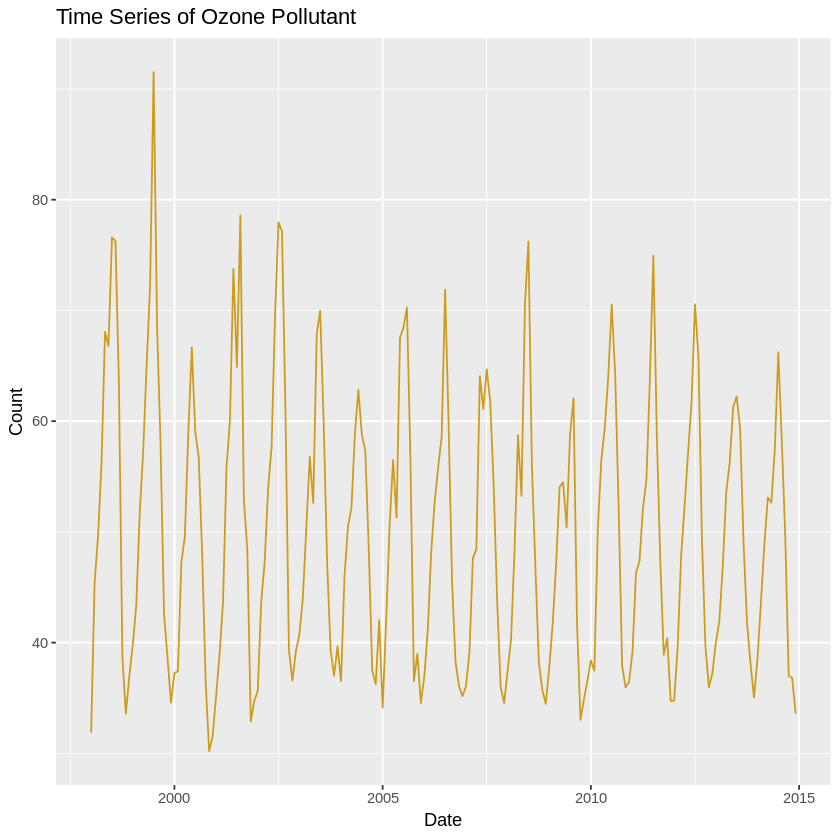

In [34]:
pollutant<-df_train%>%
     as.data.frame %>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_pol=max(O3,na.rm=TRUE))%>%
    as.data.frame %>%
    mutate(y_m=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m)%>%
   summarise(avg_emission=mean(max_pol,na.rm=TRUE))


pol_flow<-data.frame("date"=as.Date(pollutant$y_m,format="%Y - %m - %d"),"count"=pollutant$avg_emission)
  
#converting to time series    
pol_ts<-ts(pol_flow$count,frequency = 12,start = c(1998,01))

#ggplot format of ts plot    
autoplot(pol_ts,colour ="goldenrod3") +xlab('Date')+ylab('Count')+ggtitle('Time Series of Ozone Pollutant')

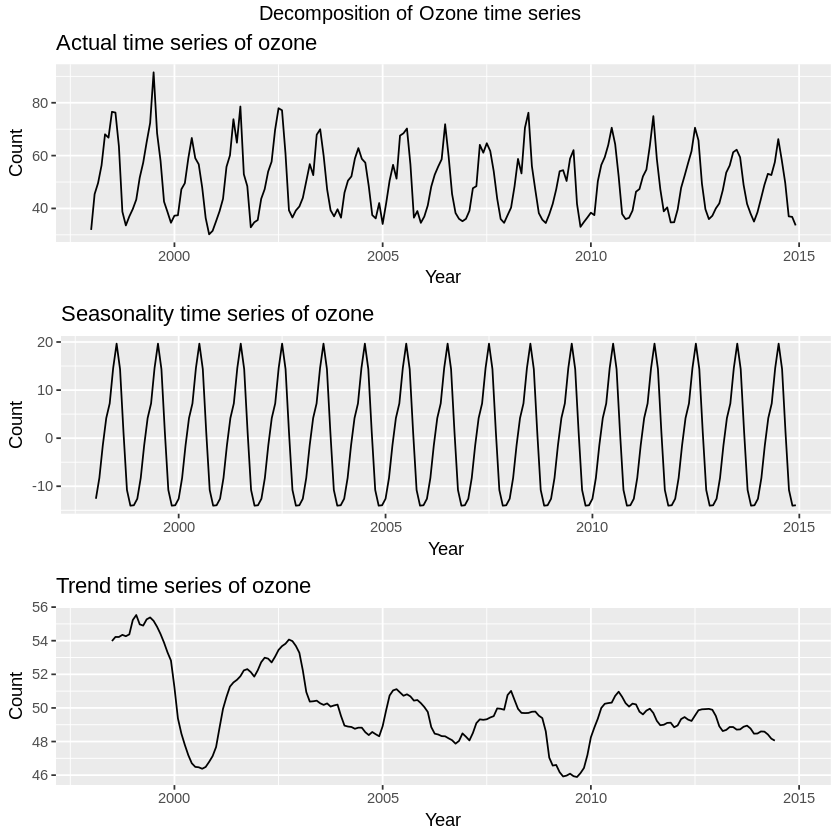

In [35]:
pol_ts_decompose<-decompose(pol_ts)

actual<-autoplot(pol_ts_decompose$x)+xlab("Year")+ylab("Count")+ggtitle("Actual time series of ozone")
seas<-autoplot(pol_ts_decompose$seasonal)+xlab("Year")+ylab("Count")+ggtitle("Seasonality time series of ozone")
tren<-autoplot(pol_ts_decompose$trend)+xlab("Year")+ylab("Count")+ggtitle("Trend time series of ozone")
grid.arrange(actual,seas,tren,ncol=1,top="Decomposition of Ozone time series")

In [36]:
train_ts<-ts(pol_ts,start = c(1998,01),end=c(2014,12),frequency = 12)
train_pol_fit_arima<-auto.arima(train_ts)
train_pol_fit_arima

Series: train_ts 
ARIMA(0,0,2)(2,1,1)[12] 

Coefficients:
         ma1     ma2     sar1     sar2     sma1
      0.2174  0.1869  -0.3739  -0.3923  -0.5645
s.e.  0.0748  0.0625   0.1017   0.0879   0.1050

sigma^2 estimated as 18.96:  log likelihood=-560.65
AIC=1133.29   AICc=1133.74   BIC=1152.84

In [37]:
train_forecast_arima<-forecast(train_pol_fit_arima,36)

In [38]:
pollutant<-df_final%>%
     as.data.frame %>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_pol=max(O3,na.rm=TRUE))%>%
    as.data.frame %>%
    mutate(y_m=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m)%>%
   summarise(avg_emission=mean(max_pol,na.rm=TRUE))


pol_flow_final<-data.frame("date"=as.Date(pollutant$y_m,format="%Y - %m - %d"),"count"=pollutant$avg_emission)
pol_ts_final<-ts(pol_flow_final$count,frequency = 12,start = c(1998,01))

In [39]:
dim(pol_flow_final)

[1] 240   2

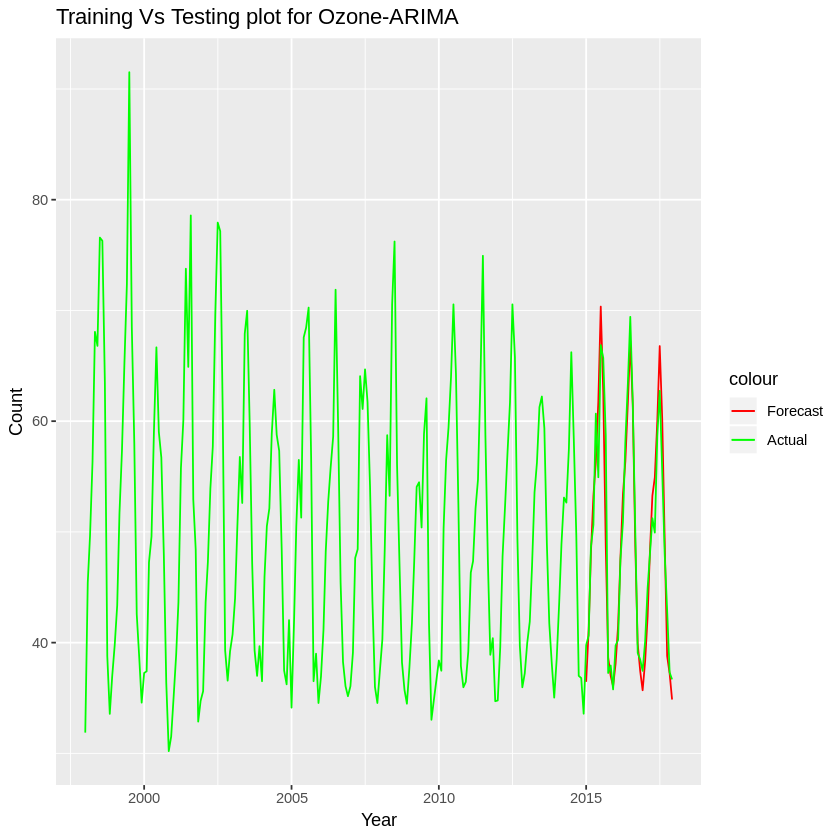

In [40]:
train_forecast_arima_df<-data.frame(train_forecast_arima)
train_forecast_arima_pt_forecast<-train_forecast_arima_df$Point.Forecast


forecast_train_arima<-data.frame("x"=as.Date(pol_flow_final$date[205:240],format="%Y - %m - %d"),"y"=train_forecast_arima_pt_forecast)
actual_train_arima<-data.frame("x"=as.Date(pol_flow_final$date,format="%Y - %m - %d"),"y"=pol_flow_final$count)

ggplot(forecast_train_arima,aes(x,y))+geom_line(aes(color="First line")) +
  geom_line(data = actual_train_arima,aes(color="Second line"))+xlab("Year")+ylab("Count")+
  labs(colors="Series")+ggtitle("Training Vs Testing plot for Ozone-ARIMA")+
  scale_colour_manual(values = c("red","green"), 
                      labels=c("Forecast", "Actual"))

In [41]:
MAPE(pol_flow_final$count[205:240],train_forecast_arima_pt_forecast)

[1] 0.04597724

In [42]:
Box.test(train_forecast_arima$residuals, lag=36, type="Ljung-Box")


	Box-Ljung test

data:  train_forecast_arima$residuals
X-squared = 39.891, df = 36, p-value = 0.3012


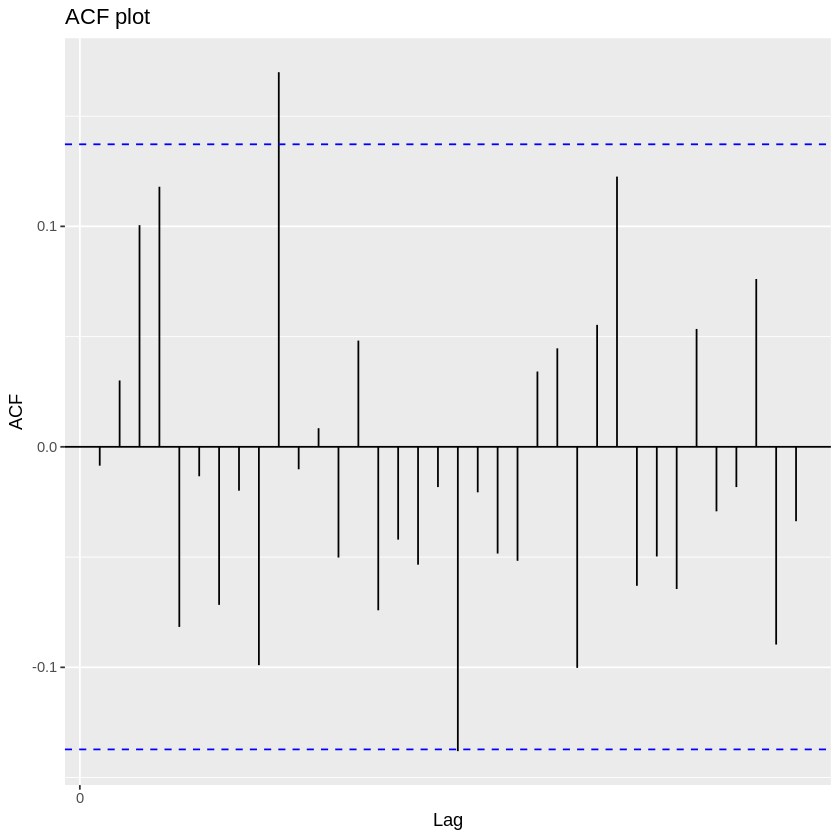

In [43]:
acf_var_arima<-acf(na.omit(train_forecast_arima$residuals),lag.max = 36,plot=FALSE)
autoplot(acf_var_arima)+labs(x='Lag',y='ACF',title='ACF plot')

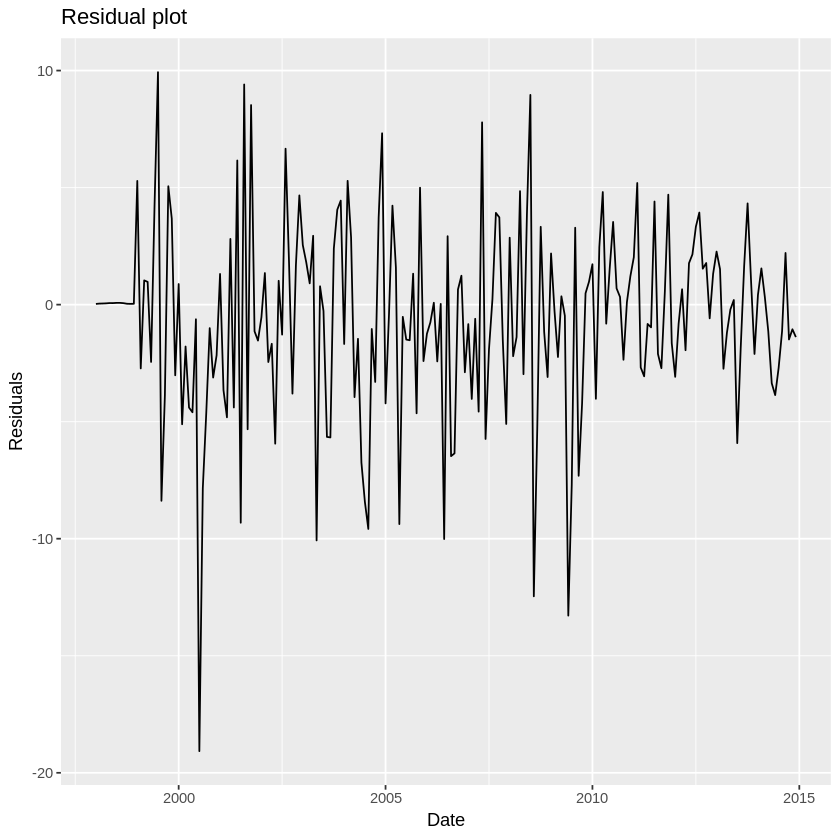

In [44]:
autoplot(train_forecast_arima$residuals)+labs(x='Date',y='Residuals',title='Residual plot')

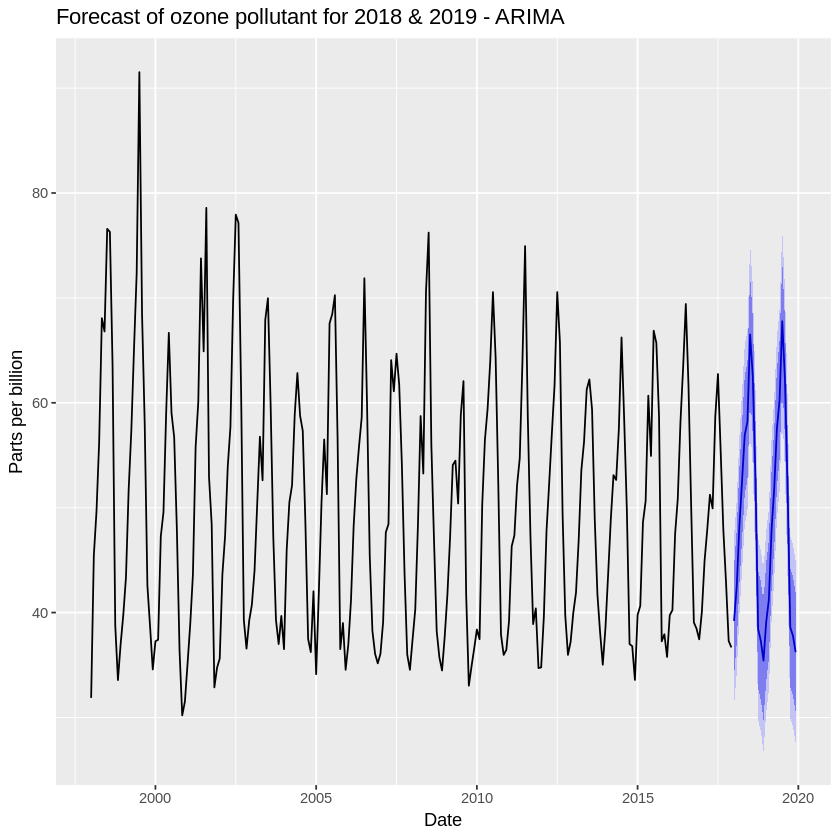

In [45]:
final_ts<-ts(pol_ts_final,start = c(1998,01),frequency = 12)
final_pol_fit_arima<-auto.arima(final_ts)
final_forecast_arima<-forecast(final_pol_fit_arima,24,level=c(80,95))
autoplot(final_forecast_arima)+labs(x='Date',y='Parts per billion',title='Forecast of ozone pollutant for 2018 & 2019 - ARIMA')

In [46]:
final_forecast_arima

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       39.20081 33.94216 44.45947 31.15840 47.24323
Feb 2018       42.43092 37.02430 47.83754 34.16220 50.69963
Mar 2018       48.25831 42.69023 53.82638 39.74268 56.77393
Apr 2018       52.58729 47.00802 58.16656 44.05453 61.12005
May 2018       56.93789 51.32141 62.55437 48.34822 65.52755
Jun 2018       58.17913 52.56264 63.79562 49.58945 66.76882
Jul 2018       66.51374 60.88463 72.14286 57.90475 75.12274
Aug 2018       62.54256 56.91185 68.17326 53.93114 71.15398
Sep 2018       52.81490 47.17808 58.45171 44.19413 61.43566
Oct 2018       38.42394 32.78470 44.06319 29.79947 47.04842
Nov 2018       37.29532 31.65228 42.93836 28.66503 45.92561
Dec 2018       35.42519 29.77974 41.07064 26.79122 44.05917
Jan 2019       39.08824 33.43540 44.74108 30.44297 47.73351
Feb 2019       41.24476 35.59050 46.89902 32.59731 49.89220
Mar 2019       47.83415 42.17697 53.49132 39.18224 56.48605
Apr 2019       51.80315 46.14442 57.4618

In [47]:
final_forecast_arima
arima_forecast_df<-as.data.frame(final_forecast_arima)
colnames(arima_forecast_df)<-c('Forecast','Lo80','Hi80','Lo95','Hi95')
arima_forecast_df <- cbind('date' = rownames(arima_forecast_df), arima_forecast_df)
arima_forecast_df$date<-gsub(" ", "-", arima_forecast_df$date)
tst <- c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

arima_forecast_df$date<-(paste("01-", arima_forecast_df$date, sep = ""))
arima_forecast_df$date<-as.Date((arima_forecast_df$date),format="%d-%b-%Y")
#arima_forecast_df$date<-as.Date(arima_forecast_df$date,format= "%d-%b-%y")
arima_forecast_df

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       39.20081 33.94216 44.45947 31.15840 47.24323
Feb 2018       42.43092 37.02430 47.83754 34.16220 50.69963
Mar 2018       48.25831 42.69023 53.82638 39.74268 56.77393
Apr 2018       52.58729 47.00802 58.16656 44.05453 61.12005
May 2018       56.93789 51.32141 62.55437 48.34822 65.52755
Jun 2018       58.17913 52.56264 63.79562 49.58945 66.76882
Jul 2018       66.51374 60.88463 72.14286 57.90475 75.12274
Aug 2018       62.54256 56.91185 68.17326 53.93114 71.15398
Sep 2018       52.81490 47.17808 58.45171 44.19413 61.43566
Oct 2018       38.42394 32.78470 44.06319 29.79947 47.04842
Nov 2018       37.29532 31.65228 42.93836 28.66503 45.92561
Dec 2018       35.42519 29.77974 41.07064 26.79122 44.05917
Jan 2019       39.08824 33.43540 44.74108 30.44297 47.73351
Feb 2019       41.24476 35.59050 46.89902 32.59731 49.89220
Mar 2019       47.83415 42.17697 53.49132 39.18224 56.48605
Apr 2019       51.80315 46.14442 57.4618

date       Forecast Lo80     Hi80     Lo95     Hi95    
Jan 2018 2018-01-01 39.20081 33.94216 44.45947 31.15840 47.24323
Feb 2018 2018-02-01 42.43092 37.02430 47.83754 34.16220 50.69963
Mar 2018 2018-03-01 48.25831 42.69023 53.82638 39.74268 56.77393
Apr 2018 2018-04-01 52.58729 47.00802 58.16656 44.05453 61.12005
May 2018 2018-05-01 56.93789 51.32141 62.55437 48.34822 65.52755
Jun 2018 2018-06-01 58.17913 52.56264 63.79562 49.58945 66.76882
Jul 2018 2018-07-01 66.51374 60.88463 72.14286 57.90475 75.12274
Aug 2018 2018-08-01 62.54256 56.91185 68.17326 53.93114 71.15398
Sep 2018 2018-09-01 52.81490 47.17808 58.45171 44.19413 61.43566
Oct 2018 2018-10-01 38.42394 32.78470 44.06319 29.79947 47.04842
Nov 2018 2018-11-01 37.29532 31.65228 42.93836 28.66503 45.92561
Dec 2018 2018-12-01 35.42519 29.77974 41.07064 26.79122 44.05917
Jan 2019 2019-01-01 39.08824 33.43540 44.74108 30.44297 47.73351
Feb 2019 2019-02-01 41.24476 35.59050 46.89902 32.59731 49.89220
Mar 2019 2019-03-01 47.83415 42.17697 53.49132 39.18224 56.48605
Apr 2019 2019-04-01 51.80315 46.14442 57.46187 43.14887 60.45742
May 2019 2019-05-01 57.53579 51.87509 63.19648 48.87850 66.19307
Jun 2019 2019-06-01 60.26905 54.60694 65.93116 51.60960 68.92850
Jul 2019 2019-07-01 67.77444 62.11087 73.43801 59.11275 76.43612
Aug 2019 2019-08-01 62.25995 56.59518 67.92471 53.59643 70.92346
Sep 2019 2019-09-01 51.79440 46.12850 57.46030 43.12916 60.45965
Oct 2019 2019-10-01 38.58794 32.92106 44.25482 29.92120 47.25468
Nov 2019 2019-11-01 37.78771 32.11993 43.45548 29.11960 46.45582
Dec 2019 2019-12-01 36.22164 30.55307 41.89020 27.55232 44.89095

In [48]:
# Converting parts per billion to AQI for Ozone
arima_forecast_df$Forecast<-((arima_forecast_df$Forecast/1000)/0.08)*100
arima_forecast_df

date       Forecast Lo80     Hi80     Lo95     Hi95    
Jan 2018 2018-01-01 49.00102 33.94216 44.45947 31.15840 47.24323
Feb 2018 2018-02-01 53.03865 37.02430 47.83754 34.16220 50.69963
Mar 2018 2018-03-01 60.32288 42.69023 53.82638 39.74268 56.77393
Apr 2018 2018-04-01 65.73411 47.00802 58.16656 44.05453 61.12005
May 2018 2018-05-01 71.17236 51.32141 62.55437 48.34822 65.52755
Jun 2018 2018-06-01 72.72391 52.56264 63.79562 49.58945 66.76882
Jul 2018 2018-07-01 83.14218 60.88463 72.14286 57.90475 75.12274
Aug 2018 2018-08-01 78.17820 56.91185 68.17326 53.93114 71.15398
Sep 2018 2018-09-01 66.01862 47.17808 58.45171 44.19413 61.43566
Oct 2018 2018-10-01 48.02993 32.78470 44.06319 29.79947 47.04842
Nov 2018 2018-11-01 46.61915 31.65228 42.93836 28.66503 45.92561
Dec 2018 2018-12-01 44.28149 29.77974 41.07064 26.79122 44.05917
Jan 2019 2019-01-01 48.86030 33.43540 44.74108 30.44297 47.73351
Feb 2019 2019-02-01 51.55594 35.59050 46.89902 32.59731 49.89220
Mar 2019 2019-03-01 59.79268 42.17697 53.49132 39.18224 56.48605
Apr 2019 2019-04-01 64.75393 46.14442 57.46187 43.14887 60.45742
May 2019 2019-05-01 71.91973 51.87509 63.19648 48.87850 66.19307
Jun 2019 2019-06-01 75.33631 54.60694 65.93116 51.60960 68.92850
Jul 2019 2019-07-01 84.71805 62.11087 73.43801 59.11275 76.43612
Aug 2019 2019-08-01 77.82493 56.59518 67.92471 53.59643 70.92346
Sep 2019 2019-09-01 64.74300 46.12850 57.46030 43.12916 60.45965
Oct 2019 2019-10-01 48.23493 32.92106 44.25482 29.92120 47.25468
Nov 2019 2019-11-01 47.23464 32.11993 43.45548 29.11960 46.45582
Dec 2019 2019-12-01 45.27705 30.55307 41.89020 27.55232 44.89095

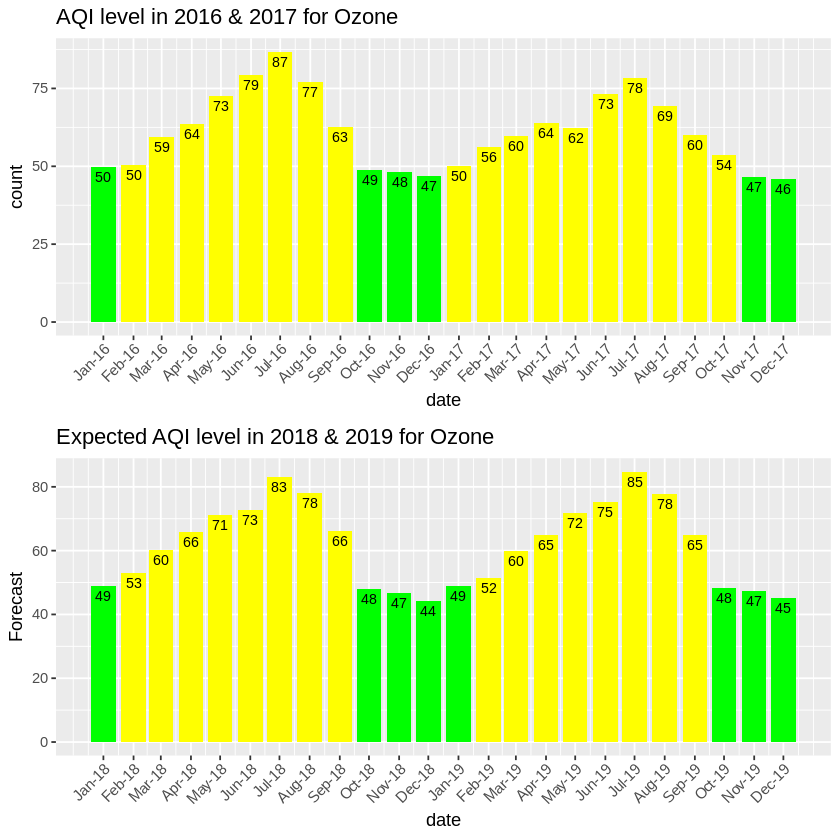

In [49]:
arima_forecast_df$colour<- cut(arima_forecast_df$Forecast, breaks = c(-Inf,50,100,150,Inf),
         labels = c("green", "yellow", "orange","red"))

after_pred<-ggplot(arima_forecast_df,aes(date,Forecast,fill=colour))+geom_bar(stat="identity",position="dodge")+
geom_text(aes(label = round(Forecast)), position = position_dodge(width = 1),
            vjust = 1.5, size = 3) +
scale_x_date(breaks = seq(as.Date("2018-01-01"), as.Date("2019-12-01"), by="1 month"), date_labels = "%b-%y")+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")+scale_fill_identity()+
ggtitle("Expected AQI level in 2018 & 2019 for Ozone")

# Converting parts per billion to AQI for Ozone
count_<-(pol_flow_final$count[217:240]/1000/0.08)*100
last_two_year<-data.frame("date"=pol_flow_final$date[217:240],"count"=count_)
last_two_year$colour<- cut(last_two_year$count, breaks = c(-Inf,50,100,150,Inf),
         labels = c("green", "yellow", "orange","red"))

before_pred<-ggplot(last_two_year,aes(date,count,fill=colour))+geom_bar(stat="identity",position="dodge")+
geom_text(aes(label = round(count)), position = position_dodge(width = 1),
            vjust = 1.5, size = 3) +
scale_x_date(breaks = seq(as.Date("2016-01-01"), as.Date("2017-12-01"), by="1 month"), date_labels = "%b-%y")+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")+scale_fill_identity()+
ggtitle("AQI level in 2016 & 2017 for Ozone")
grid.arrange(before_pred,after_pred,nrow=2)

### ETS

In [50]:
train_ts<-ts(pol_ts,start = c(1998,01),end=c(2014,12),frequency = 12)
train_pol_fit_ets<-ets(train_ts) 
train_pol_fit_ets

ETS(M,N,M) 

Call:
 ets(y = train_ts) 

  Smoothing parameters:
    alpha = 0.3542 
    gamma = 1e-04 

  Initial states:
    l = 52.5681 
    s = 0.7236 0.7212 0.7912 1.0294 1.2787 1.4003
           1.2842 1.1449 1.0864 0.9677 0.8307 0.7417

  sigma:  0.0804

     AIC     AICc      BIC 
1657.015 1659.568 1706.787 

In [51]:
train_forecast_ets<-forecast:::forecast.ets(train_pol_fit_ets,36)

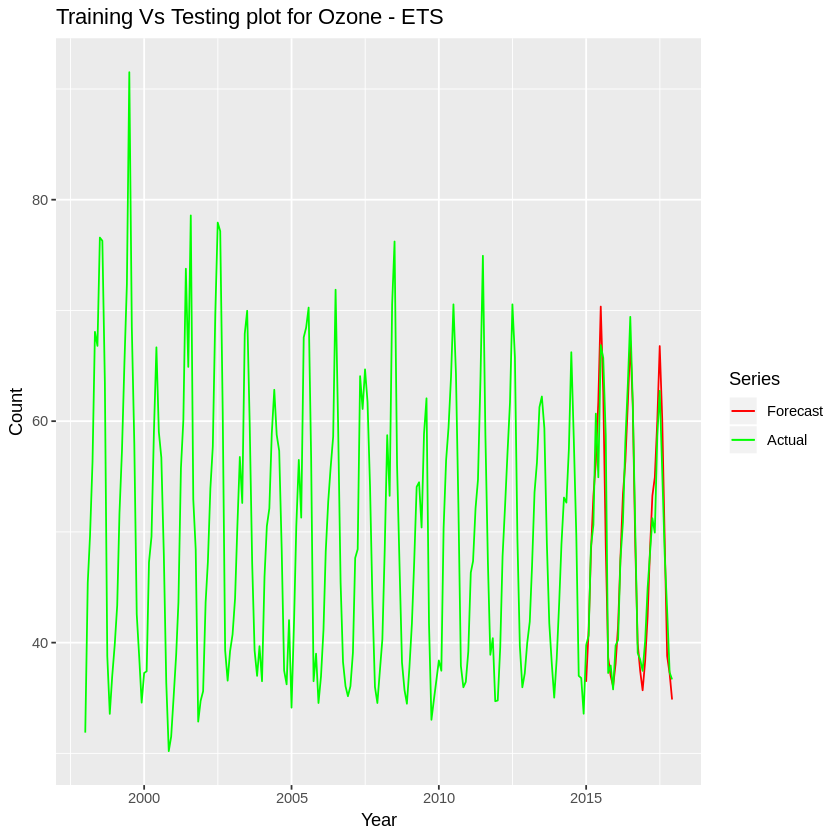

In [52]:
train_forecast_ets_df<-data.frame(train_forecast_ets)
train_forecast_ets_pt_forecast<-train_forecast_ets_df$Point.Forecast

forecast_train<-data.frame("x"=as.Date(pol_flow_final$date[205:240],format="%Y - %m - %d"),"y"=train_forecast_arima_pt_forecast)
actual_train<-data.frame("x"=as.Date(pol_flow_final$date,format="%Y - %m - %d"),"y"=pol_flow_final$count)

ggplot(forecast_train,aes(x,y))+geom_line(aes(color="First line")) +
  geom_line(data = actual_train,aes(color="Second line"))+xlab("Year")+ylab("Count")+
  labs(color="Series")+ggtitle("Training Vs Testing plot for Ozone - ETS")+
  scale_colour_manual(values = c("red","green"), 
                      labels=c("Forecast", "Actual"))

In [53]:
MAPE(pol_flow_final$count[205:240],train_forecast_ets_pt_forecast)

[1] 0.06516949

In [54]:
Box.test(train_forecast_ets$residuals, lag=36, type="Ljung-Box")


	Box-Ljung test

data:  train_forecast_ets$residuals
X-squared = 49.878, df = 36, p-value = 0.06187


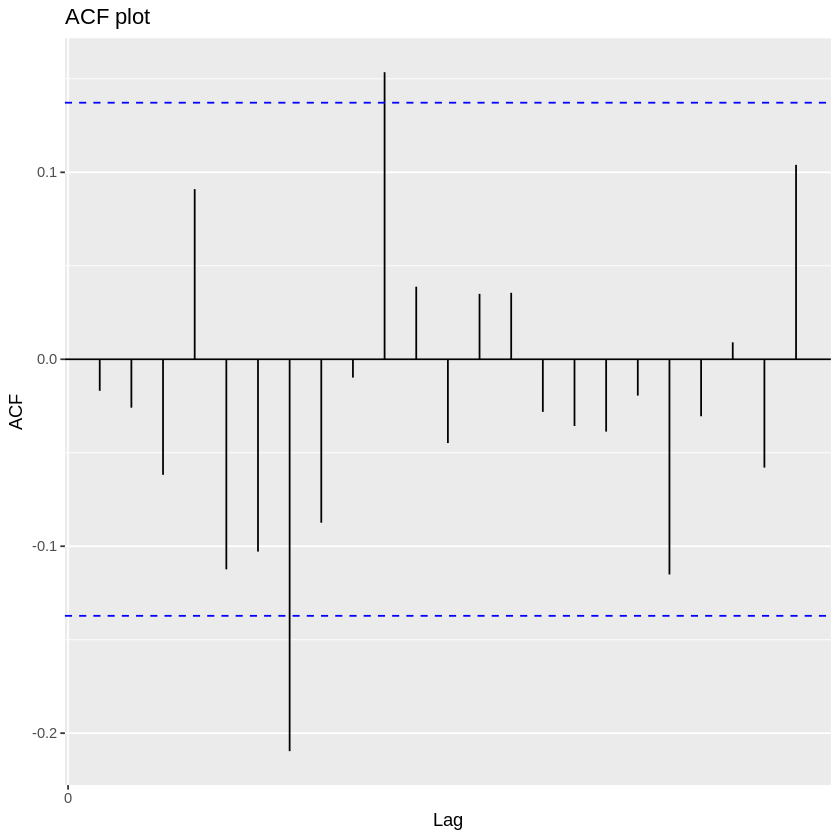

In [55]:
#ACF
acf_var_ets<-acf(na.omit(train_forecast_ets$residuals),plot=FALSE)
autoplot(acf_var_ets)+labs(x='Lag',y='ACF',title='ACF plot')

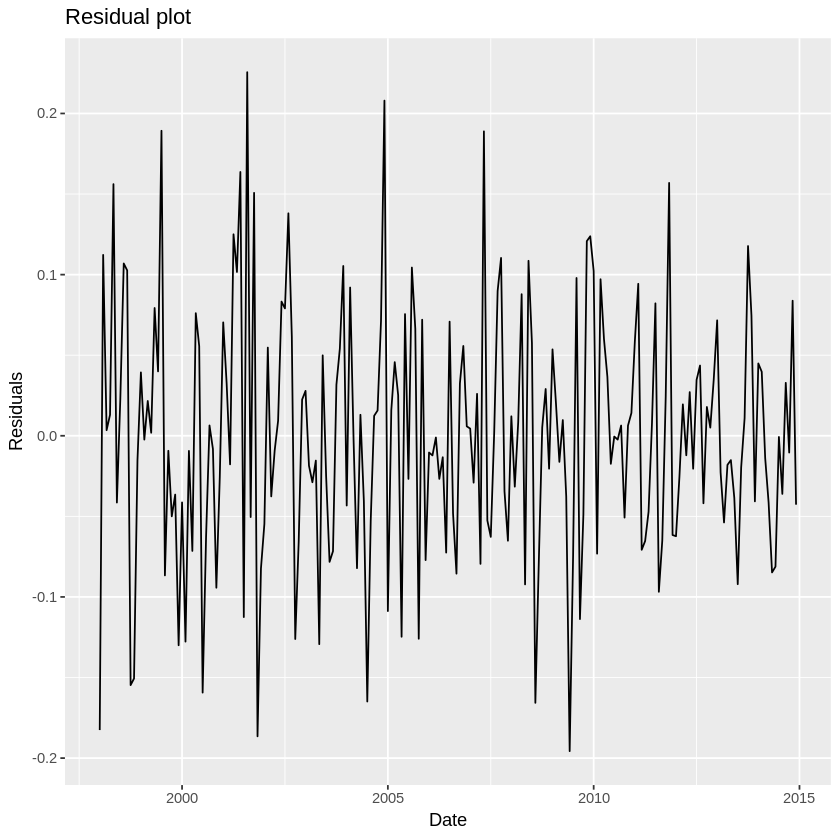

In [56]:
autoplot(train_forecast_ets$residuals)+labs(x='Date',y='Residuals',title='Residual plot')

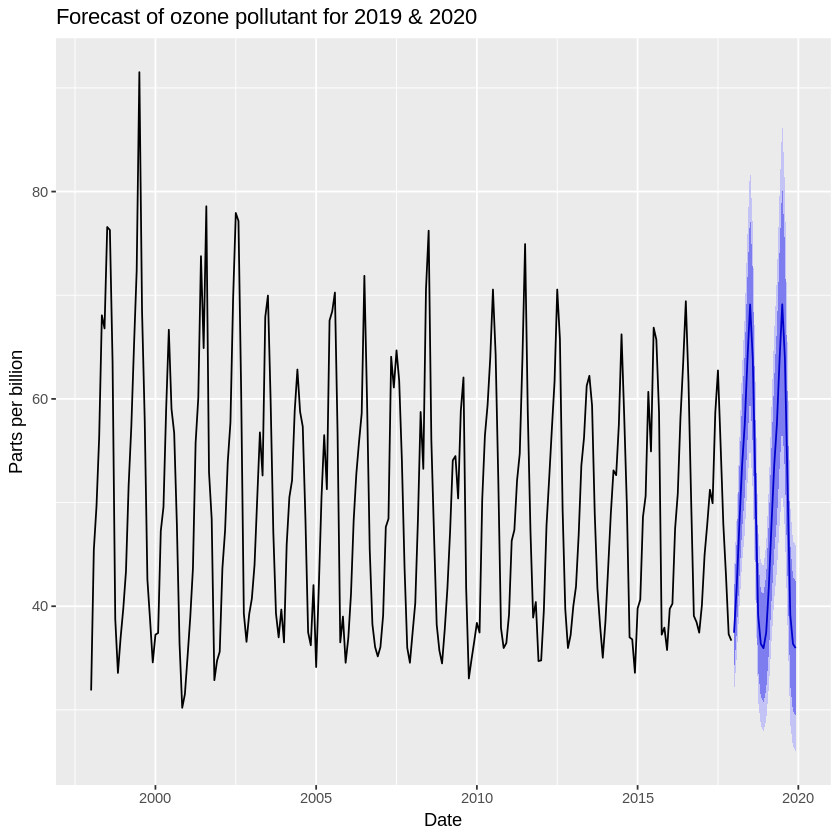

In [57]:
final_ts<-ts(pol_ts_final,start = c(1998,01),frequency = 12)
final_pol_fit_ets<-ets(final_ts)
final_forecast_ets<-forecast:::forecast.ets(final_pol_fit_ets,24)
autoplot(final_forecast_ets)+labs(x='Date',y='Parts per billion',title='Forecast of ozone pollutant for 2019 & 2020')

In [58]:
final_forecast_ets

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       37.43994 33.64328 41.23659 31.63346 43.24642
Feb 2018       41.88499 37.44347 46.32650 35.09228 48.67769
Mar 2018       47.96922 42.66930 53.26913 39.86370 56.07474
Apr 2018       53.57038 47.42245 59.71832 44.16793 62.97284
May 2018       57.54214 50.70081 64.38347 47.07923 68.00506
Jun 2018       63.77152 55.93482 71.60822 51.78632 75.75672
Jul 2018       69.10761 60.34751 77.86772 55.71019 82.50504
Aug 2018       63.84348 55.51045 72.17651 51.09921 76.58776
Sep 2018       51.33315 44.44507 58.22123 40.79874 61.86756
Oct 2018       39.14991 33.75695 44.54287 30.90209 47.39773
Nov 2018       36.36050 31.22520 41.49579 28.50674 44.21426
Dec 2018       35.95194 30.75207 41.15182 27.99942 43.90447
Jan 2019       37.44890 31.90785 42.98994 28.97460 45.92319
Feb 2019       41.89481 35.55949 48.23012 32.20578 51.58384
Mar 2019       47.98024 40.57156 55.38892 36.64964 59.31083
Apr 2019       53.58244 45.14100 62.0238

## SO2

### ARIMA

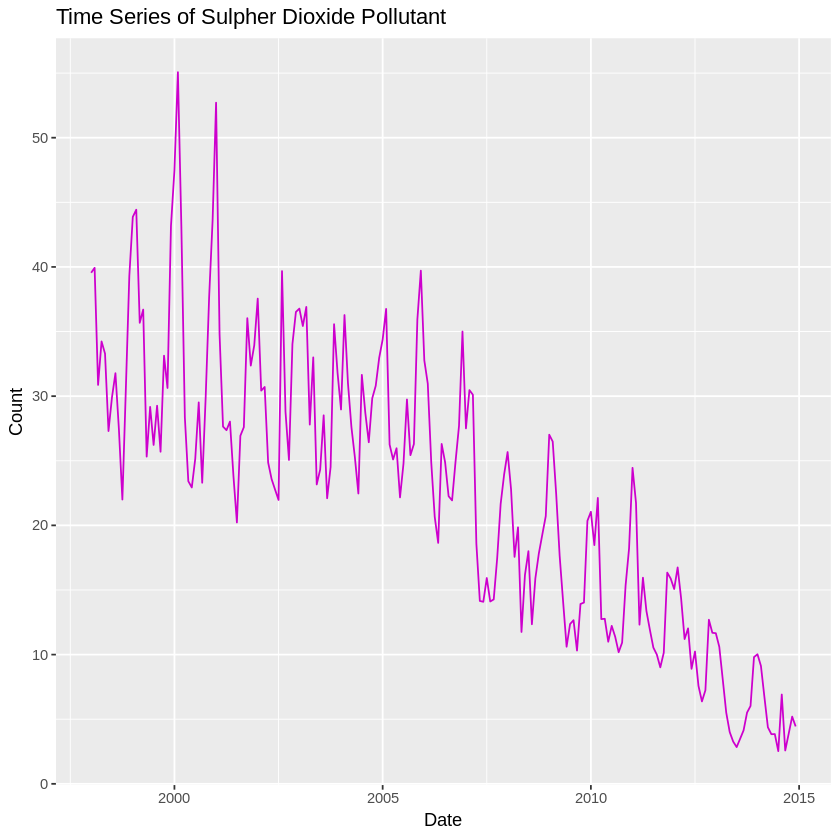

In [59]:
pollutant<-df_train%>%
     as.data.frame %>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_pol=max(SO2,na.rm=TRUE))%>%
    as.data.frame %>%
    mutate(y_m=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m)%>%
   summarise(avg_emission=mean(max_pol,na.rm=TRUE))


pol_flow<-data.frame("date"=as.Date(pollutant$y_m,format="%Y - %m - %d"),"count"=pollutant$avg_emission)
  
#converting to time series    
pol_ts<-ts(pol_flow$count,frequency = 12,start = c(1998,01))

#ggplot format of ts plot    
autoplot(pol_ts,colour ="magenta3") +xlab('Date')+ylab('Count')+ggtitle('Time Series of Sulpher Dioxide Pollutant')

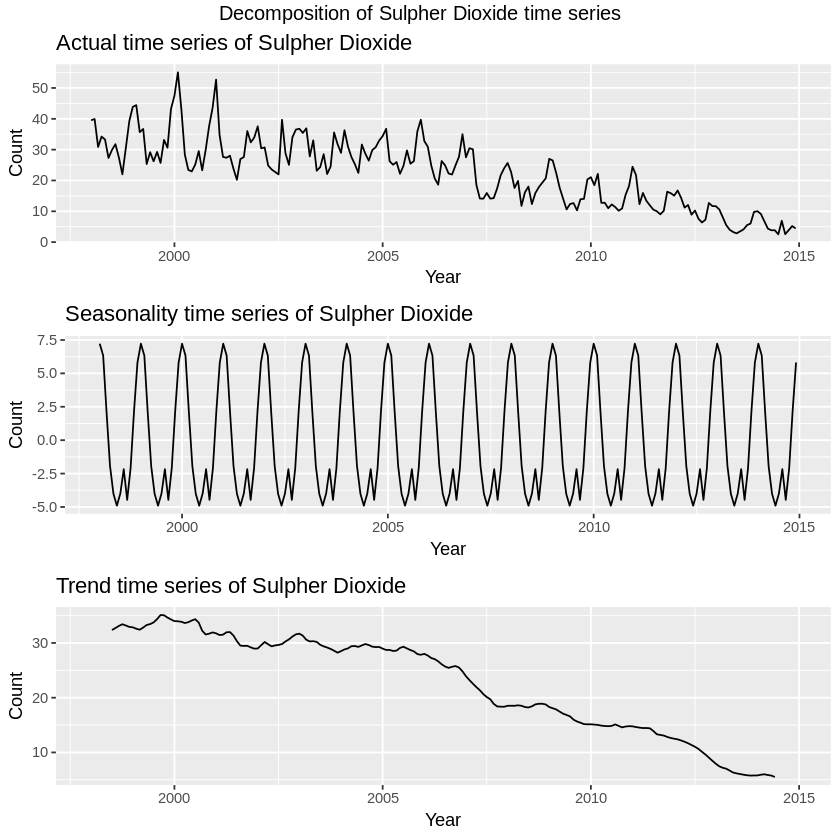

In [60]:
pol_ts_decompose<-decompose(pol_ts)

actual<-autoplot(pol_ts_decompose$x)+xlab("Year")+ylab("Count")+ggtitle("Actual time series of Sulpher Dioxide")
seas<-autoplot(pol_ts_decompose$seasonal)+xlab("Year")+ylab("Count")+ggtitle("Seasonality time series of Sulpher Dioxide")
tren<-autoplot(pol_ts_decompose$trend)+xlab("Year")+ylab("Count")+ggtitle("Trend time series of Sulpher Dioxide")
grid.arrange(actual,seas,tren,ncol=1,top="Decomposition of Sulpher Dioxide time series")

In [61]:
train_ts<-ts(pol_ts,start = c(1998,01),end=c(2014,12),frequency = 12)
train_pol_fit_arima<-auto.arima(train_ts)
train_pol_fit_arima

Series: train_ts 
ARIMA(3,0,0)(2,1,0)[12] with drift 

Coefficients:
         ar1     ar2     ar3     sar1     sar2    drift
      0.3849  0.0074  0.0688  -0.5194  -0.2386  -0.1466
s.e.  0.0730  0.0785  0.0733   0.0752   0.0742   0.0274

sigma^2 estimated as 18.11:  log likelihood=-549.41
AIC=1112.82   AICc=1113.43   BIC=1135.62

In [62]:
train_forecast_arima<-forecast(train_pol_fit_arima,36)

In [63]:
df_test$Month_Yr <- format(as.Date(df_test$date_local), "%Y-%m")
df_final <- subset(df, as.Date(date_local) >= "1998-01-01")
pollutant<-df_final%>%
     as.data.frame %>%
      mutate(date_ymd=as.Date(date_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_pol=max(SO2,na.rm=TRUE))%>%
    as.data.frame %>%
    mutate(y_m=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m)%>%
   summarise(avg_emission=mean(max_pol,na.rm=TRUE))


pol_flow_final<-data.frame("date"=as.Date(pollutant$y_m,format="%Y - %m - %d"),"count"=pollutant$avg_emission)
pol_ts_final<-(ts(pol_flow_final$count,frequency = 12,start = c(1998,01)))

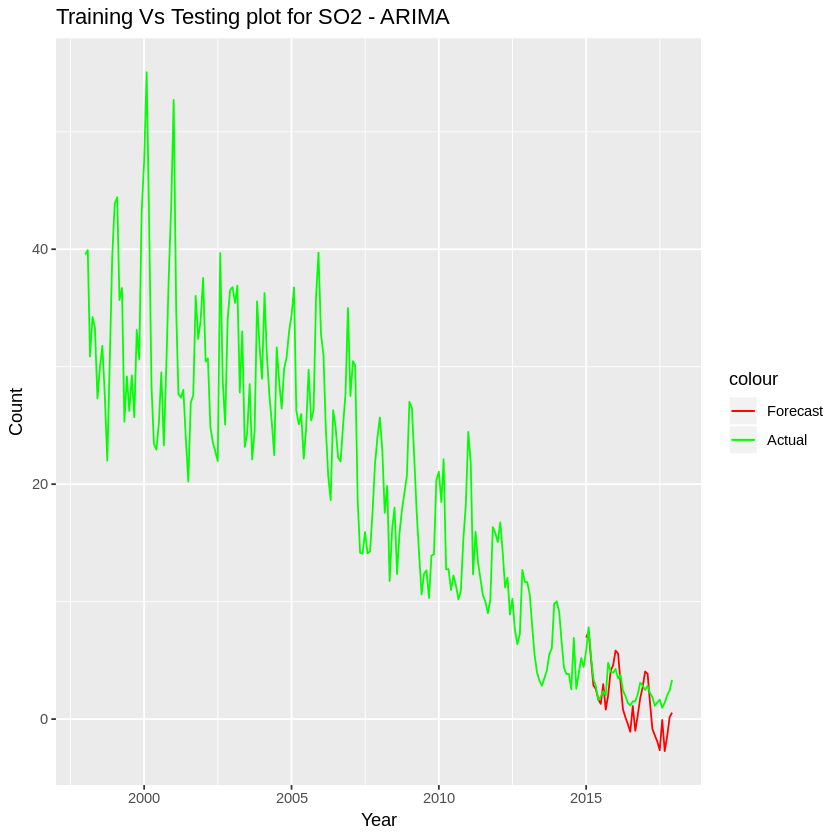

In [64]:
train_forecast_arima_df<-data.frame(train_forecast_arima)
train_forecast_arima_pt_forecast<-train_forecast_arima_df$Point.Forecast


forecast_train_arima<-data.frame("x"=as.Date(pol_flow_final$date[205:240],format="%Y - %m - %d"),"y"=train_forecast_arima_pt_forecast)
actual_train_arima<-data.frame("x"=as.Date(pol_flow_final$date,format="%Y - %m - %d"),"y"=pol_flow_final$count)

ggplot(forecast_train_arima,aes(x,y))+geom_line(aes(color="First line")) +
  geom_line(data = actual_train_arima,aes(color="Second line"))+xlab("Year")+ylab("Count")+
  labs(colors="Series")+ggtitle("Training Vs Testing plot for SO2 - ARIMA")+
  scale_colour_manual(values = c("red","green"), 
                      labels=c("Forecast", "Actual"))

In [65]:
MAPE(pol_flow_final$count[205:240],train_forecast_arima_pt_forecast)

[1] 2.228071

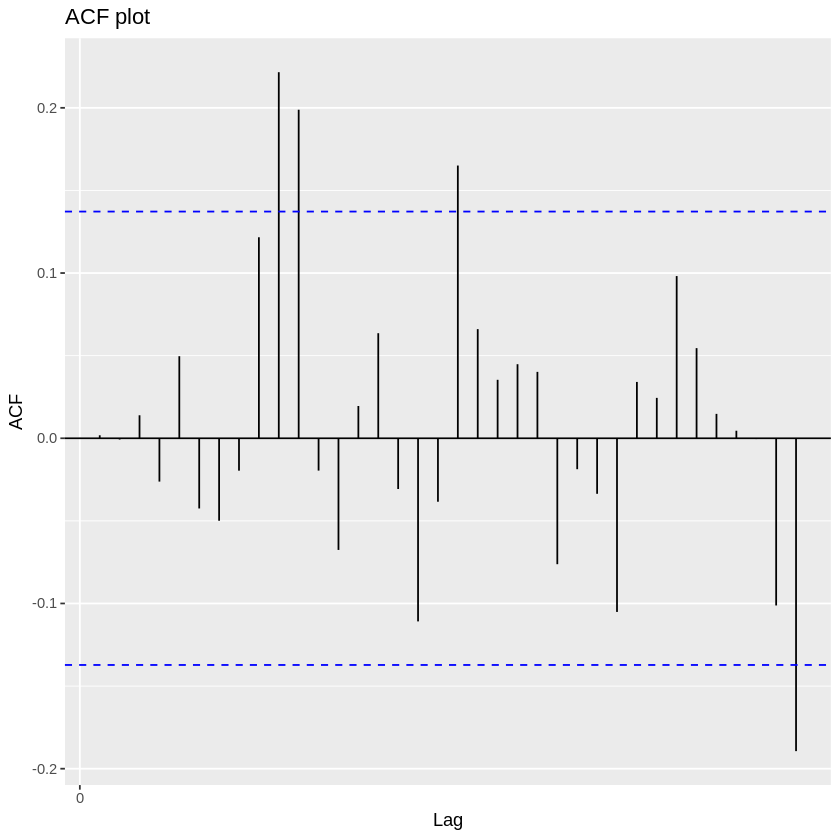

In [66]:
acf_var_arima<-acf(na.omit(train_forecast_arima$residuals),lag.max = 36,plot=FALSE)
autoplot(acf_var_arima)+labs(x='Lag',y='ACF',title='ACF plot')

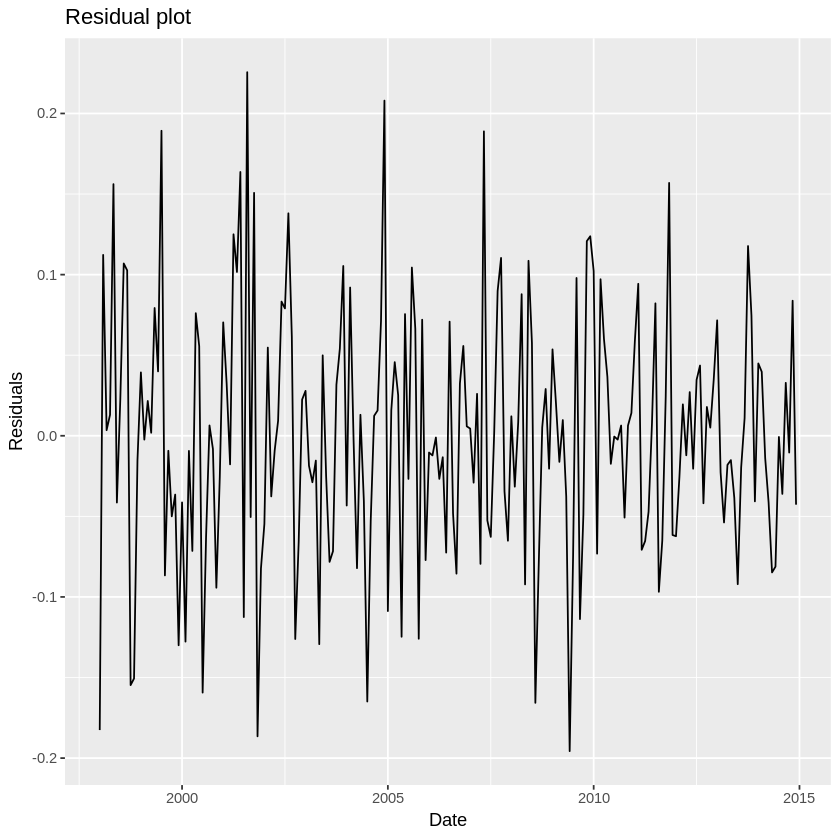

In [67]:
autoplot(train_forecast_ets$residuals)+labs(x='Date',y='Residuals',title='Residual plot')

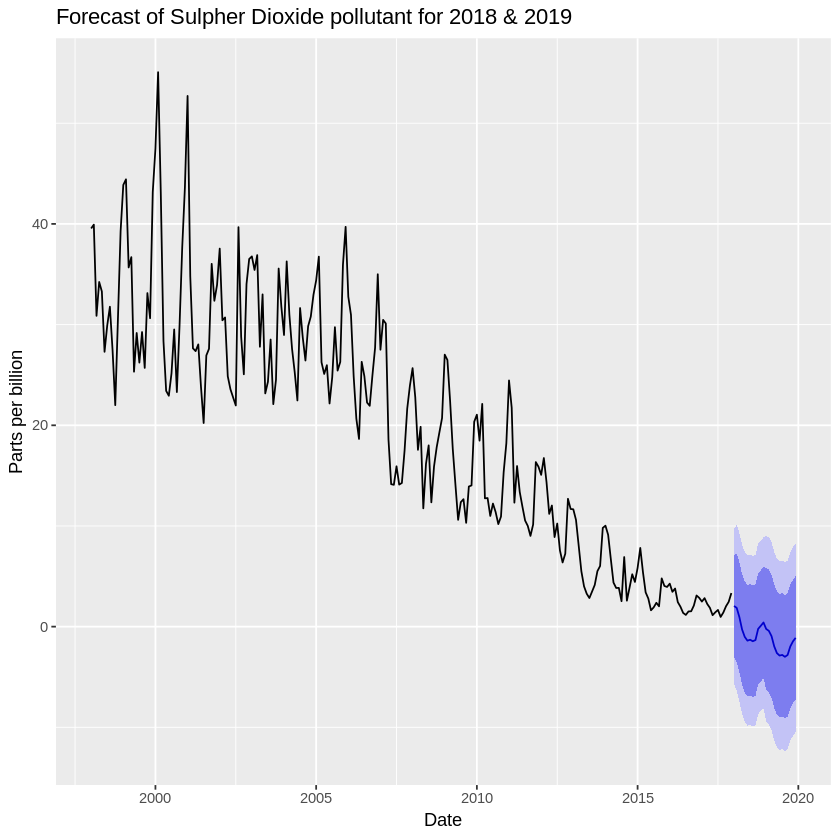

In [68]:
final_ts<-ts(pol_ts_final,start = c(1998,01),frequency = 12)
final_pol_fit_arima<-auto.arima(final_ts)
final_forecast_arima<-forecast(final_pol_fit_arima,24,level=c(80,95))
autoplot(final_forecast_arima)+labs(x='Date',y='Parts per billion',title='Forecast of Sulpher Dioxide pollutant for 2018 & 2019')

In [69]:
final_forecast_arima

         Point Forecast     Lo 80    Hi 80      Lo 95     Hi 95
Jan 2018     2.05314986 -2.973633 7.079933  -5.634651  9.740951
Feb 2018     1.86110476 -3.534925 7.257134  -6.391410 10.113620
Mar 2018     0.94183202 -4.515590 6.399254  -7.404575  9.288239
Apr 2018    -0.28066022 -5.781680 5.220360  -8.693745  8.132424
May 2018    -1.01781344 -6.534518 4.498891  -9.454884  7.419257
Jun 2018    -1.39133025 -6.912682 4.130022  -9.835509  7.052849
Jul 2018    -1.30250304 -6.825658 4.220652  -9.749439  7.144433
Aug 2018    -1.45020516 -6.974038 4.073627  -9.898178  6.997768
Sep 2018    -1.33324949 -6.857318 4.190819  -9.781584  7.115085
Oct 2018    -0.22266918 -5.746823 5.301485  -8.671134  8.225796
Nov 2018     0.08656644 -5.437619 5.610752  -8.361946  8.535079
Dec 2018     0.41202751 -5.112169 5.936224  -8.036502  8.860557
Jan 2019    -0.22858815 -6.255352 5.798176  -9.445728  8.988552
Feb 2019    -0.41897299 -6.518868 5.680922  -9.747957  8.910011
Mar 2019    -0.94445670 -7.056972 5.1680

### ETS

In [70]:
train_ts<-ts(pol_ts,start = c(1998,01),end=c(2014,12),frequency = 12)
train_pol_fit_ets<-ets(train_ts) 
train_pol_fit_ets

ETS(M,N,M) 

Call:
 ets(y = train_ts) 

  Smoothing parameters:
    alpha = 0.3838 
    gamma = 1e-04 

  Initial states:
    l = 34.2988 
    s = 1.2621 1.074 0.9005 0.7633 0.9428 0.8163
           0.7654 0.8245 0.9195 1.11 1.2836 1.338

  sigma:  0.1803

     AIC     AICc      BIC 
1619.147 1621.700 1668.919 

In [71]:
train_forecast_ets<-forecast:::forecast.ets(train_pol_fit_ets,36)

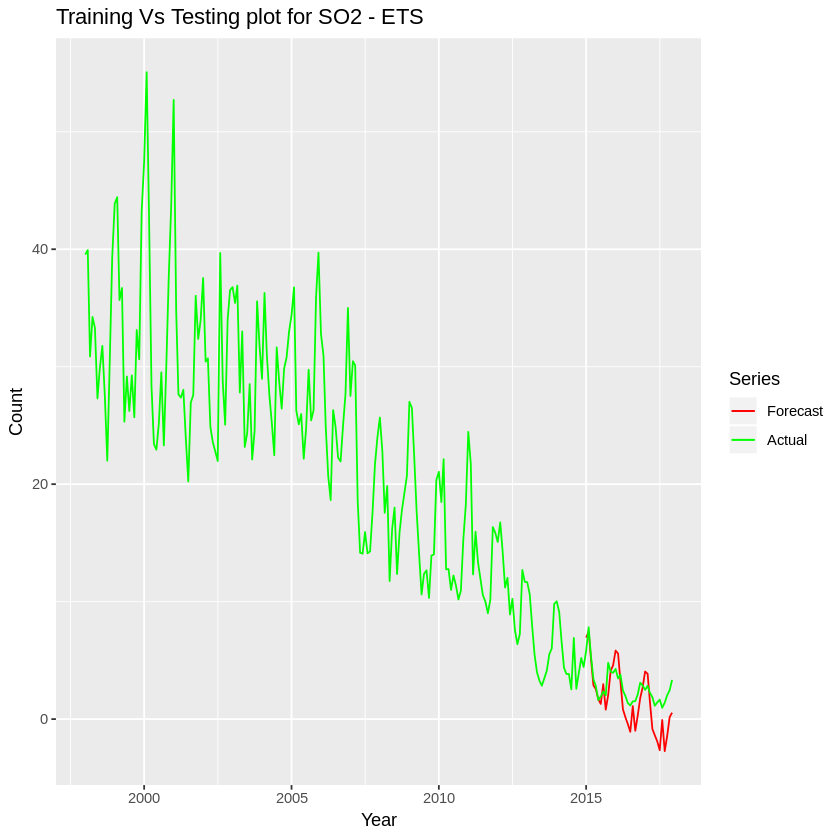

In [72]:
train_forecast_ets_df<-data.frame(train_forecast_ets)
train_forecast_ets_pt_forecast<-train_forecast_ets_df$Point.Forecast

forecast_train<-data.frame("x"=as.Date(pol_flow_final$date[205:240],format="%Y - %m - %d"),"y"=train_forecast_arima_pt_forecast)
actual_train<-data.frame("x"=as.Date(pol_flow_final$date,format="%Y - %m - %d"),"y"=pol_flow_final$count)

ggplot(forecast_train,aes(x,y))+geom_line(aes(color="First line")) +
  geom_line(data = actual_train,aes(color="Second line"))+xlab("Year")+ylab("Count")+
  labs(color="Series")+ggtitle("Training Vs Testing plot for SO2 - ETS")+
  scale_colour_manual(values = c("red","green"), 
                      labels=c("Forecast", "Actual"))

In [73]:
MAPE(pol_flow_final$count[205:240],train_forecast_ets_pt_forecast)

[1] 0.4162633

In [74]:
Box.test(train_forecast_ets$residuals, lag=36, type="Ljung-Box")


	Box-Ljung test

data:  train_forecast_ets$residuals
X-squared = 39.875, df = 36, p-value = 0.3018


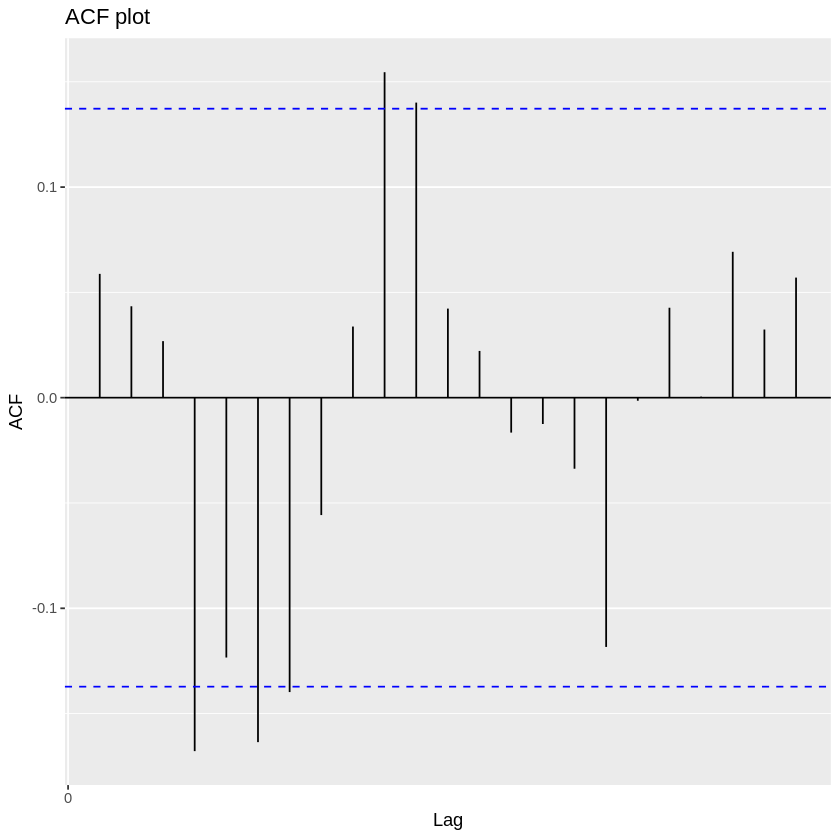

In [75]:
#ACF
acf_var_ets<-acf(na.omit(train_forecast_ets$residuals),plot=FALSE)
autoplot(acf_var_ets)+labs(x='Lag',y='ACF',title='ACF plot')

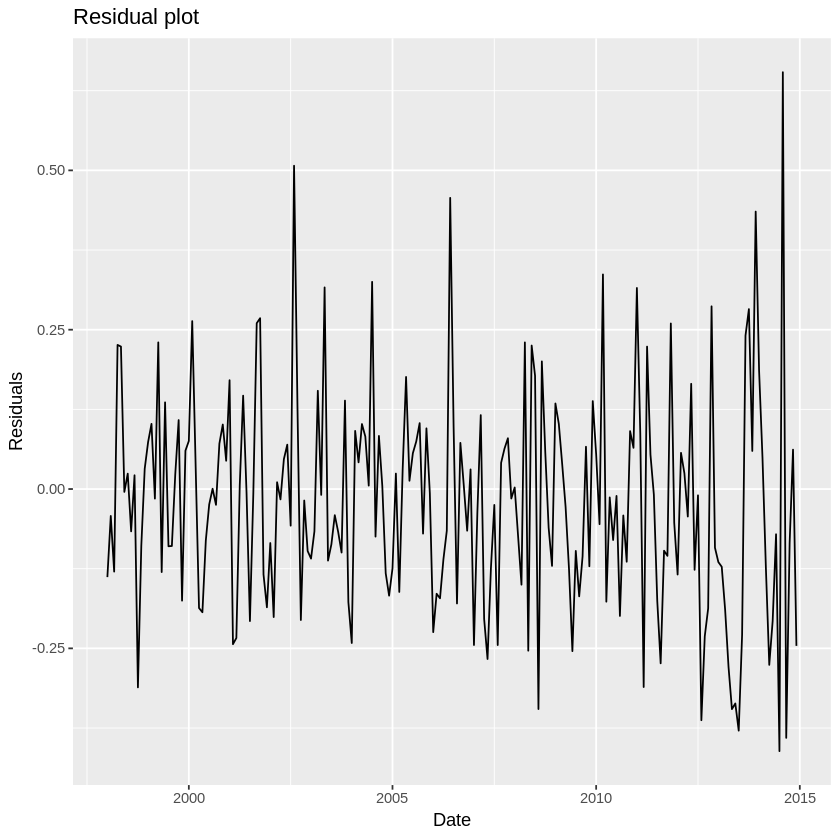

In [76]:
autoplot(train_forecast_ets$residuals)+labs(x='Date',y='Residuals',title='Residual plot')

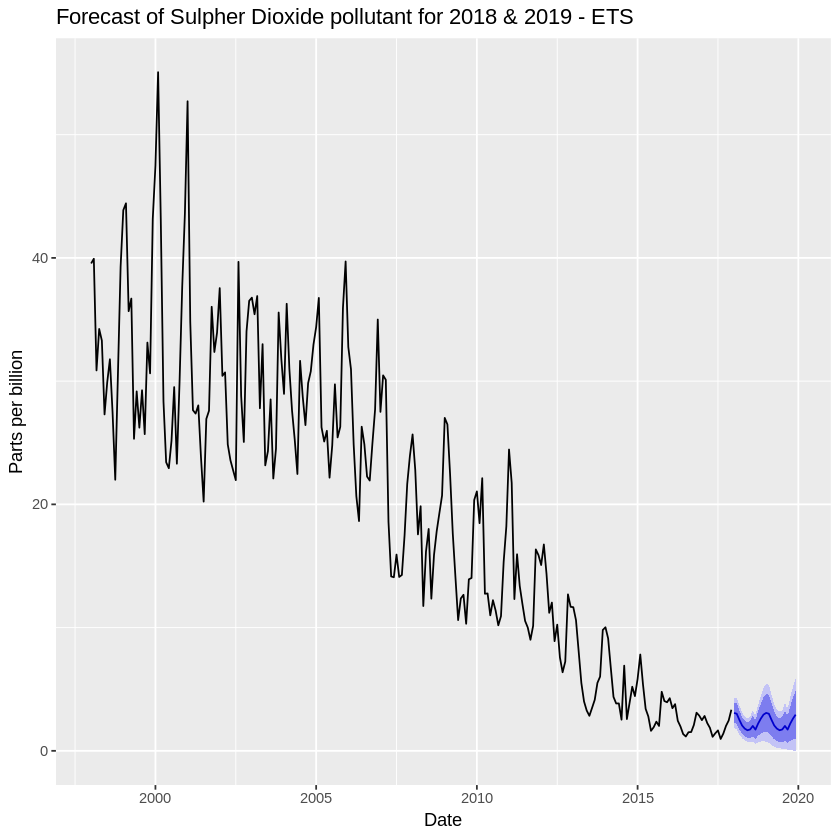

In [78]:
final_ts<-ts(pol_ts_final,start = c(1998,01),frequency = 12)
final_pol_fit_ets<-ets(final_ts)
final_forecast_ets<-forecast:::forecast.ets(final_pol_fit_ets,24)
autoplot(final_forecast_ets)+labs(x='Date',y='Parts per billion',title='Forecast of Sulpher Dioxide pollutant for 2018 & 2019 - ETS')

In [79]:
final_forecast_ets
ets_forecast_df<-as.data.frame(final_forecast_ets)
colnames(ets_forecast_df)<-c('Forecast','Lo80','Hi80','Lo95','Hi95')
ets_forecast_df <- cbind('date' = rownames(ets_forecast_df), ets_forecast_df)
ets_forecast_df$date<-gsub(" ", "-", ets_forecast_df$date)
tst <- c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

ets_forecast_df$date<-(paste("01-", ets_forecast_df$date, sep = ""))
ets_forecast_df$date<-as.Date((ets_forecast_df$date),format="%d-%b-%Y")
#ets_forecast_df$date<-as.Date(ets_forecast_df$date,format= "%d-%b-%y")
ets_forecast_df

         Point Forecast     Lo 80    Hi 80       Lo 95    Hi 95
Jan 2018       3.076131 2.2994136 3.852849  1.88824406 4.264019
Feb 2018       3.009817 2.1669826 3.852651  1.72081317 4.298820
Mar 2018       2.509056 1.7430646 3.275048  1.33757317 3.680539
Apr 2018       2.057986 1.3812994 2.734672  1.02308336 3.092888
May 2018       1.802905 1.1701967 2.435614  0.83526099 2.770550
Jun 2018       1.669876 1.0488063 2.290946  0.72003180 2.619721
Jul 2018       1.733311 1.0539280 2.412694  0.69428443 2.772337
Aug 2018       2.017551 1.1879896 2.847113  0.74884606 3.286257
Sep 2018       1.725132 0.9838706 2.466394  0.59147031 2.858794
Oct 2018       2.215549 1.2239145 3.207184  0.69897476 3.732124
Nov 2018       2.613987 1.3986611 3.829313  0.75530651 4.472667
Dec 2018       2.938390 1.5226723 4.354109  0.77323633 5.103545
Jan 2019       3.076137 1.5434736 4.608800  0.73213070 5.420143
Feb 2019       3.009822 1.4619078 4.557737  0.64249136 5.377153
Mar 2019       2.509061 1.1793124 3.8388

date       Forecast Lo80      Hi80     Lo95        Hi95    
Jan 2018 2018-01-01 3.076131 2.2994136 3.852849  1.88824406 4.264019
Feb 2018 2018-02-01 3.009817 2.1669826 3.852651  1.72081317 4.298820
Mar 2018 2018-03-01 2.509056 1.7430646 3.275048  1.33757317 3.680539
Apr 2018 2018-04-01 2.057986 1.3812994 2.734672  1.02308336 3.092888
May 2018 2018-05-01 1.802905 1.1701967 2.435614  0.83526099 2.770550
Jun 2018 2018-06-01 1.669876 1.0488063 2.290946  0.72003180 2.619721
Jul 2018 2018-07-01 1.733311 1.0539280 2.412694  0.69428443 2.772337
Aug 2018 2018-08-01 2.017551 1.1879896 2.847113  0.74884606 3.286257
Sep 2018 2018-09-01 1.725132 0.9838706 2.466394  0.59147031 2.858794
Oct 2018 2018-10-01 2.215549 1.2239145 3.207184  0.69897476 3.732124
Nov 2018 2018-11-01 2.613987 1.3986611 3.829313  0.75530651 4.472667
Dec 2018 2018-12-01 2.938390 1.5226723 4.354109  0.77323633 5.103545
Jan 2019 2019-01-01 3.076137 1.5434736 4.608800  0.73213070 5.420143
Feb 2019 2019-02-01 3.009822 1.4619078 4.557737  0.64249136 5.377153
Mar 2019 2019-03-01 2.509061 1.1793124 3.838809  0.47538613 4.542735
Apr 2019 2019-04-01 2.057989 0.9356708 3.180308  0.34155117 3.774428
May 2019 2019-05-01 1.802909 0.7925207 2.813297  0.25765361 3.348164
Jun 2019 2019-06-01 1.669879 0.7093238 2.630435  0.20083642 3.138922
Jul 2019 2019-07-01 1.733314 0.7110419 2.755586  0.16988378 3.296744
Aug 2019 2019-08-01 2.017555 0.7987434 3.236367  0.15354340 3.881567
Sep 2019 2019-09-01 1.725136 0.6586314 2.791640  0.09405819 3.356213
Oct 2019 2019-10-01 2.215553 0.8150393 3.616067  0.07365195 4.357454
Nov 2019 2019-11-01 2.613992 0.9257243 4.302259  0.03200954 5.195974
Dec 2019 2019-12-01 2.938396 1.0007703 4.876021 -0.02494669 5.901738

In [80]:
# Converting parts per billion to AQI for SO2
ets_forecast_df$Forecast<-((ets_forecast_df$Forecast/1000)/0.14)*100
ets_forecast_df

date       Forecast Lo80      Hi80     Lo95        Hi95    
Jan 2018 2018-01-01 2.197237 2.2994136 3.852849  1.88824406 4.264019
Feb 2018 2018-02-01 2.149869 2.1669826 3.852651  1.72081317 4.298820
Mar 2018 2018-03-01 1.792183 1.7430646 3.275048  1.33757317 3.680539
Apr 2018 2018-04-01 1.469990 1.3812994 2.734672  1.02308336 3.092888
May 2018 2018-05-01 1.287790 1.1701967 2.435614  0.83526099 2.770550
Jun 2018 2018-06-01 1.192769 1.0488063 2.290946  0.72003180 2.619721
Jul 2018 2018-07-01 1.238079 1.0539280 2.412694  0.69428443 2.772337
Aug 2018 2018-08-01 1.441108 1.1879896 2.847113  0.74884606 3.286257
Sep 2018 2018-09-01 1.232237 0.9838706 2.466394  0.59147031 2.858794
Oct 2018 2018-10-01 1.582535 1.2239145 3.207184  0.69897476 3.732124
Nov 2018 2018-11-01 1.867133 1.3986611 3.829313  0.75530651 4.472667
Dec 2018 2018-12-01 2.098850 1.5226723 4.354109  0.77323633 5.103545
Jan 2019 2019-01-01 2.197241 1.5434736 4.608800  0.73213070 5.420143
Feb 2019 2019-02-01 2.149873 1.4619078 4.557737  0.64249136 5.377153
Mar 2019 2019-03-01 1.792186 1.1793124 3.838809  0.47538613 4.542735
Apr 2019 2019-04-01 1.469992 0.9356708 3.180308  0.34155117 3.774428
May 2019 2019-05-01 1.287792 0.7925207 2.813297  0.25765361 3.348164
Jun 2019 2019-06-01 1.192771 0.7093238 2.630435  0.20083642 3.138922
Jul 2019 2019-07-01 1.238081 0.7110419 2.755586  0.16988378 3.296744
Aug 2019 2019-08-01 1.441111 0.7987434 3.236367  0.15354340 3.881567
Sep 2019 2019-09-01 1.232240 0.6586314 2.791640  0.09405819 3.356213
Oct 2019 2019-10-01 1.582538 0.8150393 3.616067  0.07365195 4.357454
Nov 2019 2019-11-01 1.867137 0.9257243 4.302259  0.03200954 5.195974
Dec 2019 2019-12-01 2.098854 1.0007703 4.876021 -0.02494669 5.901738

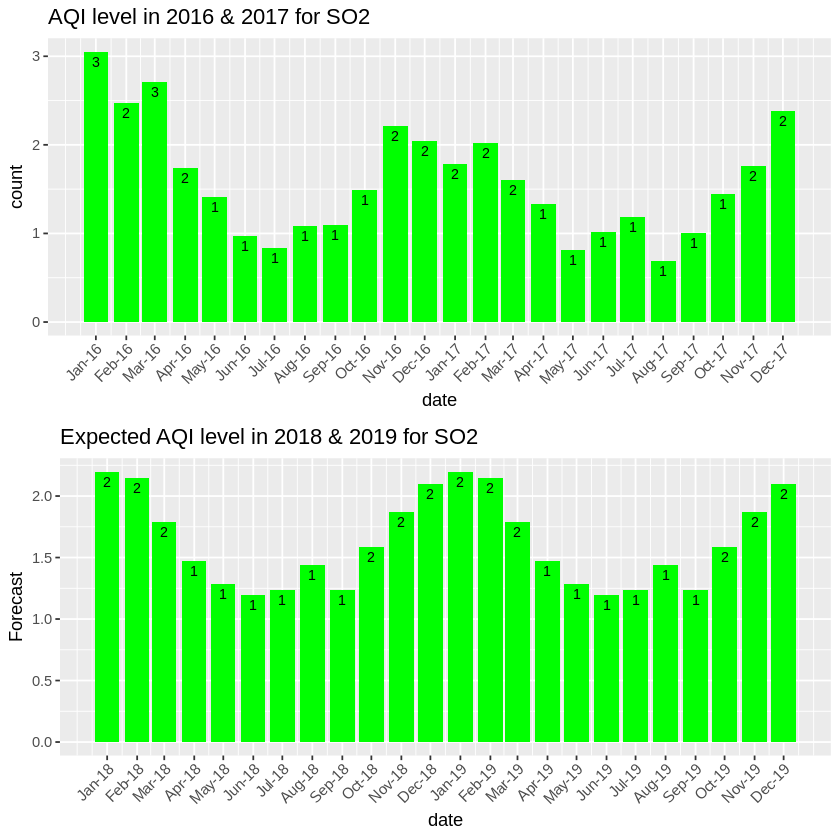

In [81]:
ets_forecast_df$colour<- cut(ets_forecast_df$Forecast, breaks = c(-Inf,50,100,150,Inf),
         labels = c("green", "yellow", "orange","red"))

after_pred<-ggplot(ets_forecast_df,aes(date,Forecast,fill=colour))+geom_bar(stat="identity",position="dodge")+
geom_text(aes(label = round(Forecast)), position = position_dodge(width = 1),
            vjust = 1.5, size = 3) +
scale_x_date(breaks = seq(as.Date("2018-01-01"), as.Date("2019-12-01"), by="1 month"), date_labels = "%b-%y")+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")+scale_fill_identity()+
ggtitle("Expected AQI level in 2018 & 2019 for SO2")

# Converting parts per billion to AQI for SO2
count_<-(((pol_flow_final$count[217:240])/1000)/0.14)*100
last_two_year<-data.frame("date"=pol_flow_final$date[217:240],"count"=count_)
last_two_year$colour<- cut(last_two_year$count, breaks = c(-Inf,50,100,150,Inf),
         labels = c("green", "yellow", "orange","red"))

before_pred<-ggplot(last_two_year,aes(date,count,fill=colour))+geom_bar(stat="identity",position="dodge")+
geom_text(aes(label = round(count)), position = position_dodge(width = 1),
            vjust = 1.5, size = 3) +
scale_x_date(breaks = seq(as.Date("2016-01-01"), as.Date("2017-12-01"), by="1 month"), date_labels = "%b-%y")+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")+scale_fill_identity()+
ggtitle("AQI level in 2016 & 2017 for SO2")
grid.arrange(before_pred,after_pred,nrow=2)

# NO2

### ARIMA

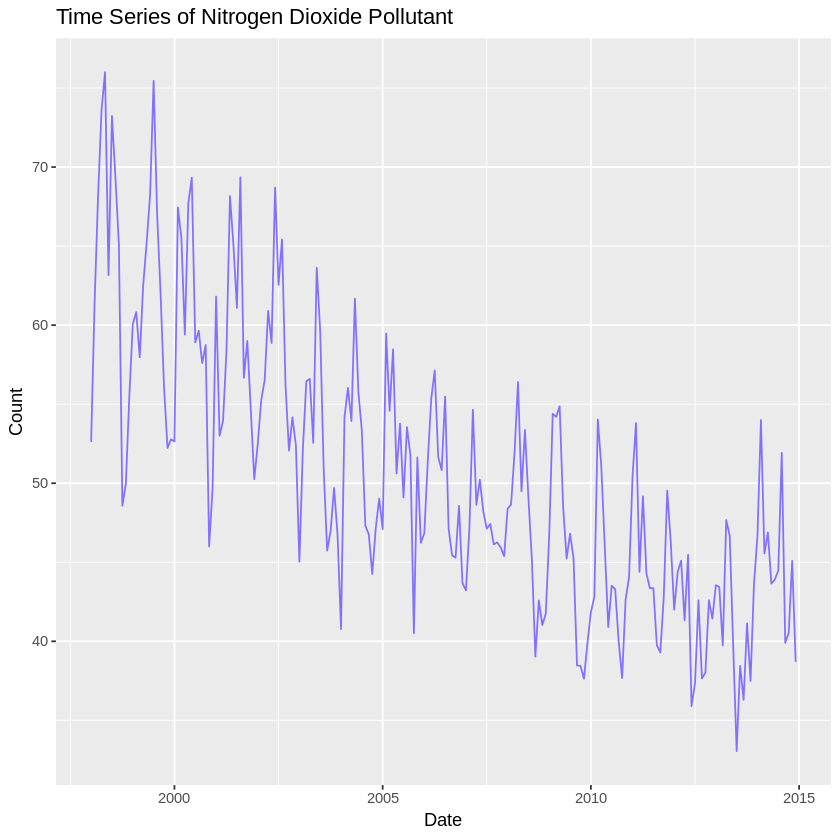

In [82]:
pollutant<-df_train%>%
     as.data.frame %>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_pol=max(NO2,na.rm=TRUE))%>%
    as.data.frame %>%
    mutate(y_m=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m)%>%
   summarise(avg_emission=mean(max_pol,na.rm=TRUE))


pol_flow<-data.frame("date"=as.Date(pollutant$y_m,format="%Y - %m - %d"),"count"=pollutant$avg_emission)
  
#converting to time series    
pol_ts<-ts(pol_flow$count,frequency = 12,start = c(1998,01))

#ggplot format of ts plot    
autoplot(pol_ts,colour ="lightslateblue") +xlab('Date')+ylab('Count')+ggtitle('Time Series of Nitrogen Dioxide Pollutant')

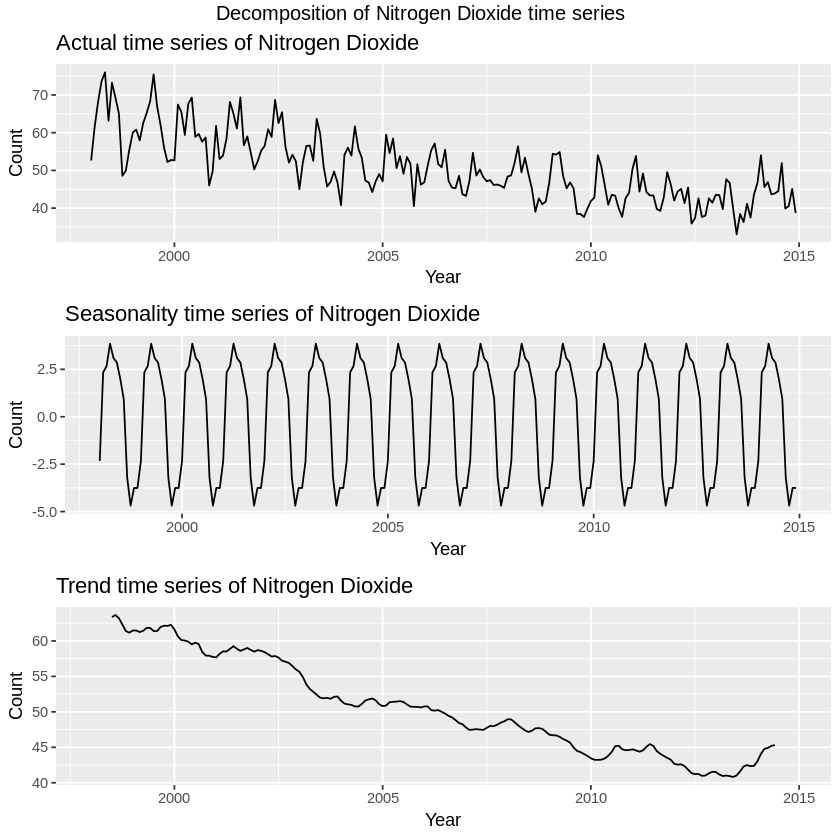

In [83]:
pol_ts_decompose<-decompose(pol_ts)

actual<-autoplot(pol_ts_decompose$x)+xlab("Year")+ylab("Count")+ggtitle("Actual time series of Nitrogen Dioxide")
seas<-autoplot(pol_ts_decompose$seasonal)+xlab("Year")+ylab("Count")+ggtitle("Seasonality time series of Nitrogen Dioxide")
tren<-autoplot(pol_ts_decompose$trend)+xlab("Year")+ylab("Count")+ggtitle("Trend time series of Nitrogen Dioxide")
grid.arrange(actual,seas,tren,ncol=1,top="Decomposition of Nitrogen Dioxide time series")

In [84]:
train_ts<-ts(pol_ts,start = c(1998,01),end=c(2014,12),frequency = 12)
train_pol_fit_arima<-auto.arima(train_ts,approx=FALSE)
train_pol_fit_arima

Series: train_ts 
ARIMA(1,1,1)(0,0,2)[12] 

Coefficients:
         ar1      ma1    sma1    sma2
      0.4165  -0.9374  0.2873  0.1485
s.e.  0.0757   0.0202  0.0816  0.0771

sigma^2 estimated as 22.57:  log likelihood=-603.51
AIC=1217.02   AICc=1217.33   BIC=1233.59

In [85]:
train_forecast_arima<-forecast(train_pol_fit_arima,36)

In [86]:
pollutant<-df_final%>%
     as.data.frame %>%
      mutate(date_ymd=as.Date(datetime_local,format="%Y-%m-%d"))%>%
           group_by(date_ymd)%>%
         summarise(max_pol=max(NO2,na.rm=TRUE))%>%
    as.data.frame %>%
    mutate(y_m=paste(substr(date_ymd,1,nchar(date_ymd)+2),"-01"))%>%
    group_by(y_m)%>%
   summarise(avg_emission=mean(max_pol,na.rm=TRUE))


pol_flow_final<-data.frame("date"=as.Date(pollutant$y_m,format="%Y - %m - %d"),"count"=pollutant$avg_emission)
pol_ts_final<-ts(pol_flow_final$count,frequency = 12,start = c(1998,01))

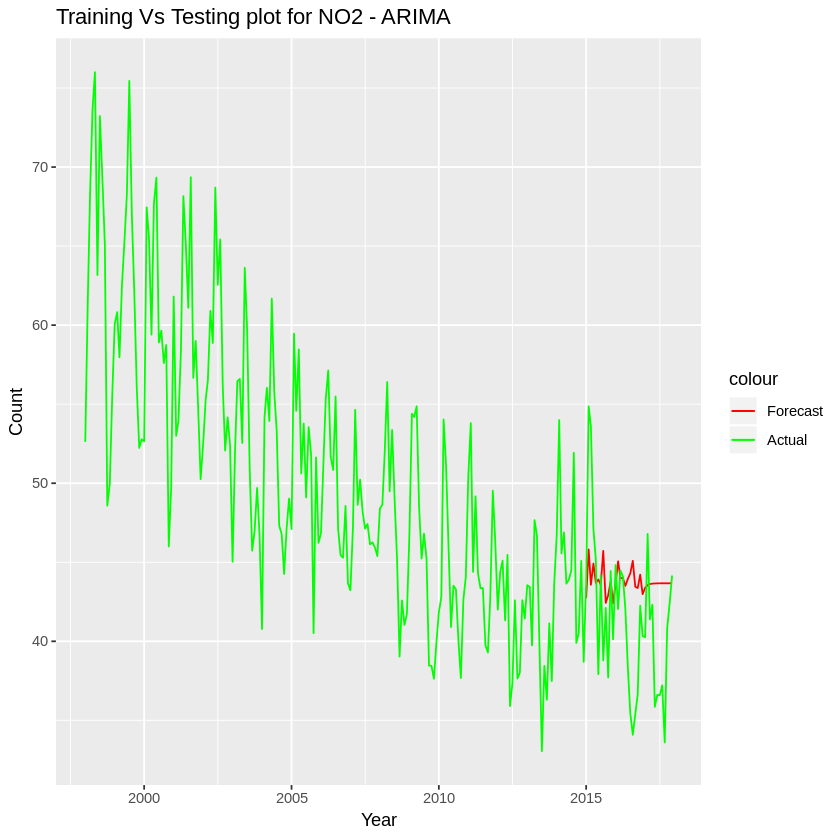

In [87]:
train_forecast_arima_df<-data.frame(train_forecast_arima)
train_forecast_arima_pt_forecast<-train_forecast_arima_df$Point.Forecast


forecast_train_arima<-data.frame("x"=as.Date(pol_flow_final$date[205:240],format="%Y - %m - %d"),"y"=train_forecast_arima_pt_forecast)
actual_train_arima<-data.frame("x"=as.Date(pol_flow_final$date,format="%Y - %m - %d"),"y"=pol_flow_final$count)

ggplot(forecast_train_arima,aes(x,y))+geom_line(aes(color="First line")) +
  geom_line(data = actual_train_arima,aes(color="Second line"))+xlab("Year")+ylab("Count")+
  labs(colors="Series")+ggtitle("Training Vs Testing plot for NO2 - ARIMA")+
  scale_colour_manual(values = c("red","green"), 
                      labels=c("Forecast", "Actual"))

In [88]:
MAPE(pol_flow_final$count[205:240],train_forecast_arima_pt_forecast)

[1] 0.09460125

In [89]:
Box.test(train_forecast_arima$residuals, lag=36, type="Ljung-Box")


	Box-Ljung test

data:  train_forecast_arima$residuals
X-squared = 94.293, df = 36, p-value = 4.065e-07


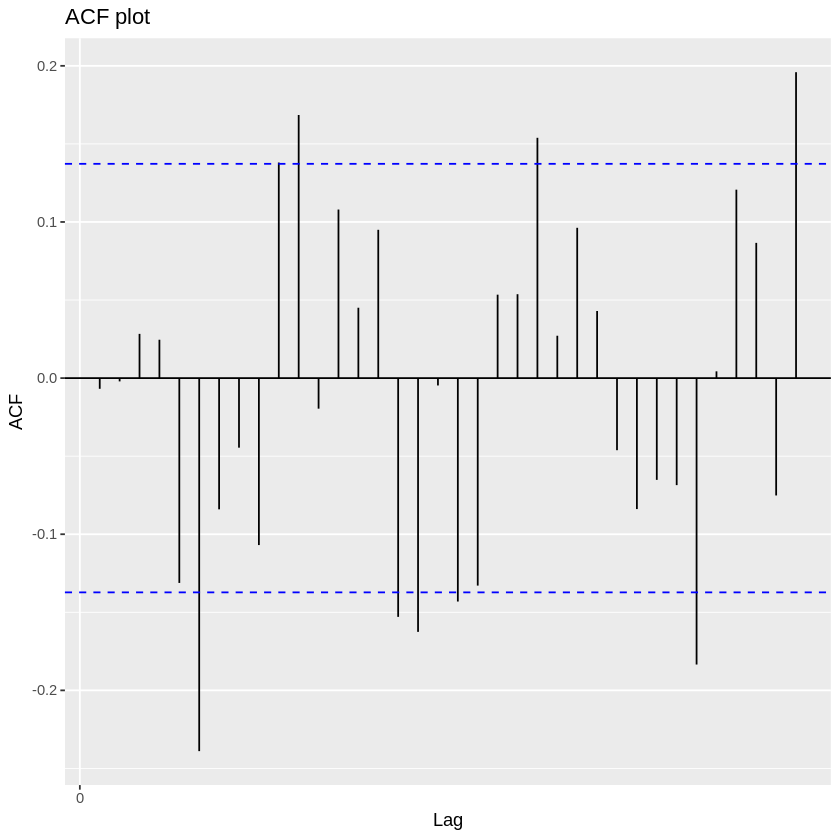

In [90]:
acf_var_arima<-acf(na.omit(train_forecast_arima$residuals),lag.max = 36,plot=FALSE)
autoplot(acf_var_arima)+labs(x='Lag',y='ACF',title='ACF plot')

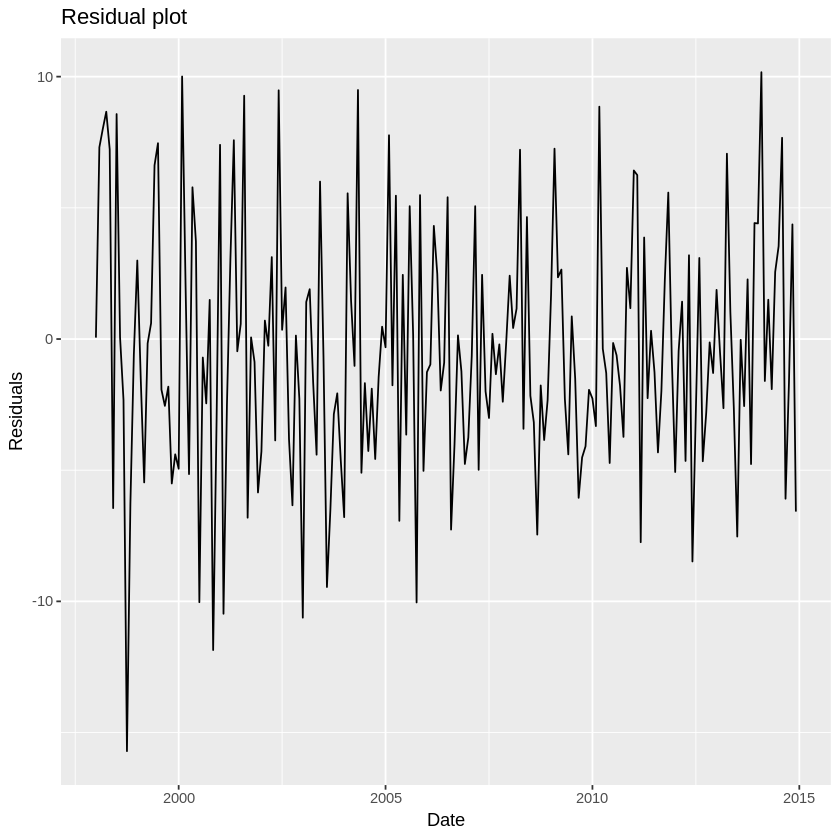

In [91]:
autoplot(train_forecast_arima$residuals)+labs(x='Date',y='Residuals',title='Residual plot')

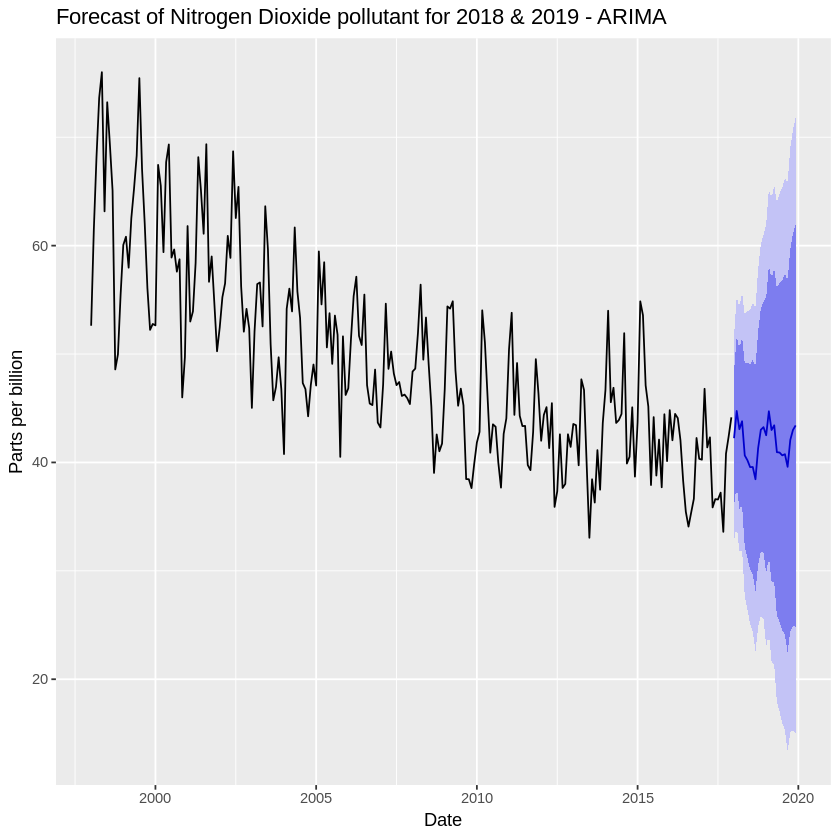

In [92]:
final_ts<-ts(pol_ts_final,start = c(1998,01),frequency = 12)
final_pol_fit_arima<-auto.arima(final_ts)
final_forecast_arima<-forecast(final_pol_fit_arima,24,level=c(80,95))
autoplot(final_forecast_arima)+labs(x='Date',y='Parts per billion',title='Forecast of Nitrogen Dioxide pollutant for 2018 & 2019 - ARIMA')

In [93]:
final_forecast_arima

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       42.23814 36.06779 48.40850 32.80140 51.67489
Feb 2018       44.74888 37.85188 51.64588 34.20083 55.29692
Mar 2018       43.06821 35.70980 50.42661 31.81449 54.32192
Apr 2018       43.79705 36.04030 51.55381 31.93412 55.65998
May 2018       40.64627 32.18344 49.10911 27.70349 53.58906
Jun 2018       40.20208 31.19862 49.20554 26.43247 53.97169
Jul 2018       39.57108 30.09887 49.04328 25.08459 54.05756
Aug 2018       39.57634 29.66998 49.48270 24.42586 54.72681
Sep 2018       38.44954 28.08841 48.81067 22.60356 54.29552
Oct 2018       41.32440 30.53438 52.11441 24.82249 57.82630
Nov 2018       43.01363 31.81746 54.20979 25.89056 60.13669
Dec 2018       43.25547 31.67018 54.84076 25.53730 60.97364
Jan 2019       42.50753 29.78565 55.22940 23.05110 61.96395
Feb 2019       44.71985 31.34612 58.09358 24.26649 65.17320
Mar 2019       42.99242 29.05279 56.93206 21.67359 64.31125
Apr 2019       43.42447 28.95262 57.8963

### ETS

In [94]:
train_ts<-ts(pol_ts,start = c(1998,01),end=c(2014,12),frequency = 12)
train_pol_fit_ets<-ets(train_ts) 
train_pol_fit_ets

ETS(M,N,M) 

Call:
 ets(y = train_ts) 

  Smoothing parameters:
    alpha = 0.1506 
    gamma = 0.2751 

  Initial states:
    l = 61.648 
    s = 0.8796 0.8747 0.9174 0.9947 1.0825 1.1155
           1.0788 1.1045 1.0556 1.0112 0.985 0.9006

  sigma:  0.0896

     AIC     AICc      BIC 
1717.599 1720.152 1767.371 

In [95]:
train_forecast_ets<-forecast:::forecast.ets(train_pol_fit_ets,36)

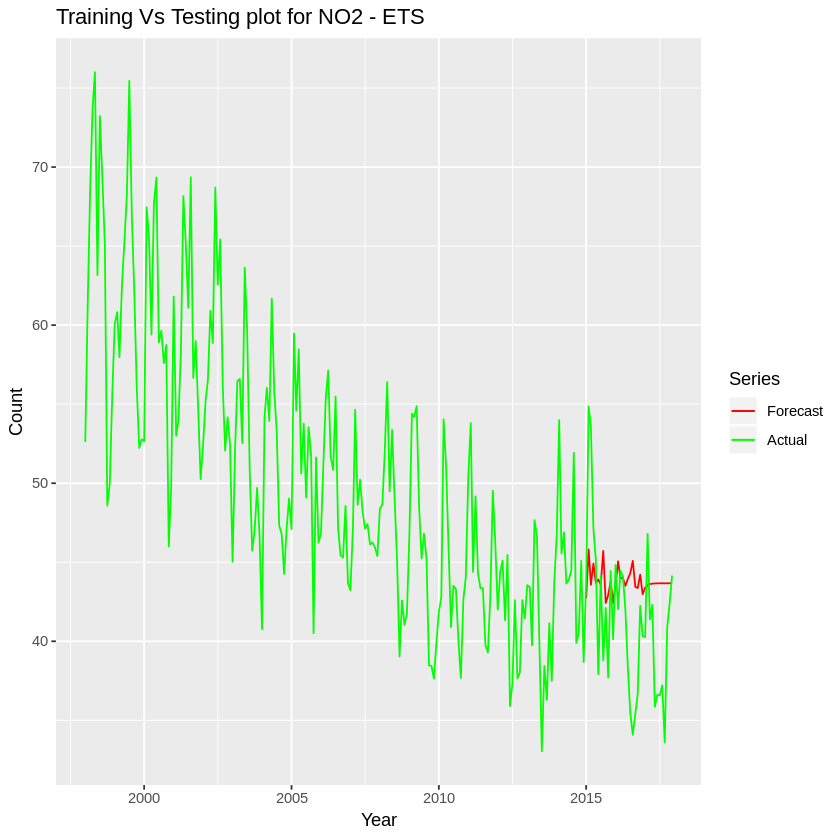

In [97]:
train_forecast_ets_df<-data.frame(train_forecast_ets)
train_forecast_ets_pt_forecast<-train_forecast_ets_df$Point.Forecast

forecast_train<-data.frame("x"=as.Date(pol_flow_final$date[205:240],format="%Y - %m - %d"),"y"=train_forecast_arima_pt_forecast)
actual_train<-data.frame("x"=as.Date(pol_flow_final$date,format="%Y - %m - %d"),"y"=pol_flow_final$count)

ggplot(forecast_train,aes(x,y))+geom_line(aes(color="First line")) +
  geom_line(data = actual_train,aes(color="Second line"))+xlab("Year")+ylab("Count")+
  labs(color="Series")+ggtitle("Training Vs Testing plot for NO2 - ETS")+
  scale_colour_manual(values = c("red","green"), 
                      labels=c("Forecast", "Actual"))

In [98]:
MAPE(pol_flow_final$count[205:240],train_forecast_ets_pt_forecast)

[1] 0.09393799

In [99]:
Box.test(train_forecast_ets$residuals, lag=36, type="Ljung-Box")


	Box-Ljung test

data:  train_forecast_ets$residuals
X-squared = 55.038, df = 36, p-value = 0.02202


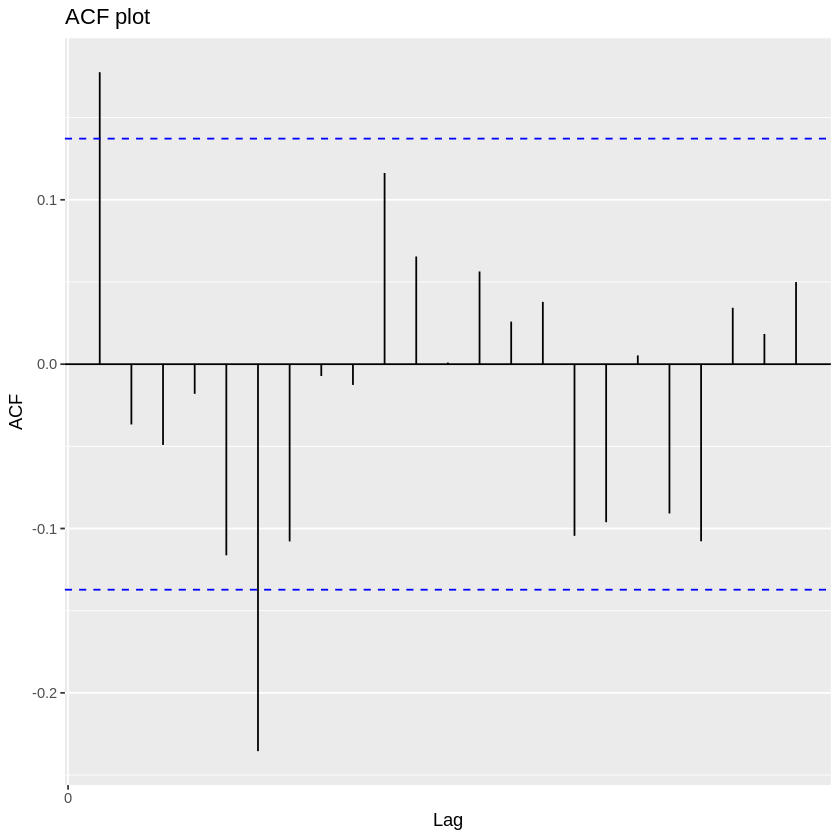

In [100]:
#ACF
acf_var_ets<-acf(na.omit(train_forecast_ets$residuals),plot=FALSE)
autoplot(acf_var_ets)+labs(x='Lag',y='ACF',title='ACF plot')

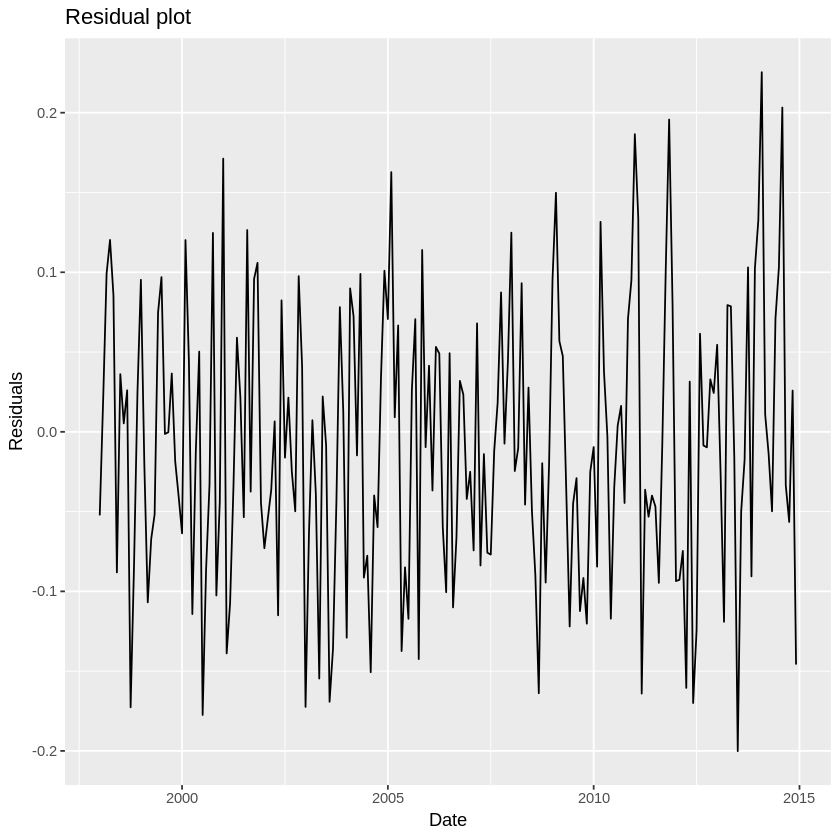

In [101]:
autoplot(train_forecast_ets$residuals)+labs(x='Date',y='Residuals',title='Residual plot')

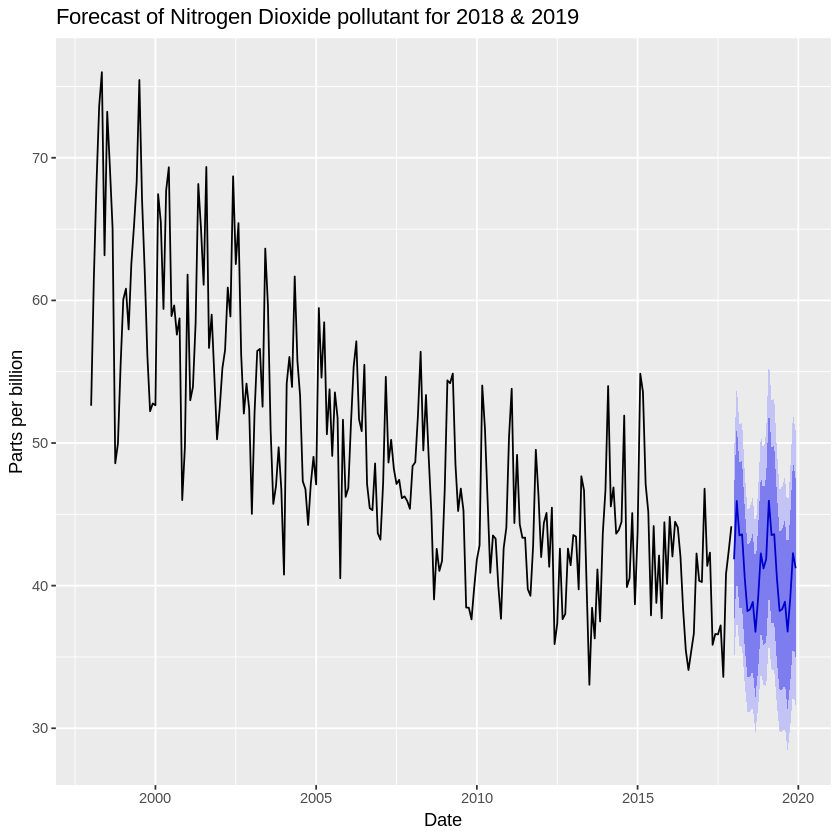

In [102]:
final_ts<-ts(pol_ts_final,start = c(1998,01),frequency = 12)
final_pol_fit_ets<-ets(final_ts)
final_forecast_ets<-forecast:::forecast.ets(final_pol_fit_ets,24)
autoplot(final_forecast_ets)+labs(x='Date',y='Parts per billion',title='Forecast of Nitrogen Dioxide pollutant for 2018 & 2019')

In [103]:
final_forecast_ets
ets_forecast_df<-as.data.frame(final_forecast_ets)
colnames(ets_forecast_df)<-c('Forecast','Lo80','Hi80','Lo95','Hi95')
ets_forecast_df <- cbind('date' = rownames(ets_forecast_df), ets_forecast_df)
ets_forecast_df$date<-gsub(" ", "-", ets_forecast_df$date)
tst <- c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

ets_forecast_df$date<-(paste("01-", ets_forecast_df$date, sep = ""))
ets_forecast_df$date<-as.Date((ets_forecast_df$date),format="%d-%b-%Y")
#ets_forecast_df$date<-as.Date(ets_forecast_df$date,format= "%d-%b-%y")
ets_forecast_df

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       41.84795 37.09366 46.60224 34.57689 49.11901
Feb 2018       45.93754 40.64716 51.22792 37.84660 54.02848
Mar 2018       43.52520 38.44580 48.60461 35.75692 51.29348
Apr 2018       43.59316 38.43974 48.74659 35.71168 51.47465
May 2018       40.53363 35.68121 45.38605 33.11249 47.95476
Jun 2018       38.21275 33.58165 42.84384 31.13010 45.29539
Jul 2018       38.34036 33.63777 43.04295 31.14837 45.53235
Aug 2018       38.85749 34.03534 43.67964 31.48265 46.23233
Sep 2018       36.76577 32.15069 41.38085 29.70762 43.82393
Oct 2018       39.13933 34.17103 44.10764 31.54096 46.73770
Nov 2018       42.25988 36.83641 47.68336 33.96540 50.55437
Dec 2018       41.20627 35.86105 46.55149 33.03146 49.38108
Jan 2019       41.86288 36.03979 47.68598 32.95724 50.76853
Feb 2019       45.95393 39.50302 52.40484 36.08811 55.81975
Mar 2019       43.54073 37.37339 49.70807 34.10860 52.97286
Apr 2019       43.60872 37.37696 49.8404

date       Forecast Lo80     Hi80     Lo95     Hi95    
Jan 2018 2018-01-01 41.84795 37.09366 46.60224 34.57689 49.11901
Feb 2018 2018-02-01 45.93754 40.64716 51.22792 37.84660 54.02848
Mar 2018 2018-03-01 43.52520 38.44580 48.60461 35.75692 51.29348
Apr 2018 2018-04-01 43.59316 38.43974 48.74659 35.71168 51.47465
May 2018 2018-05-01 40.53363 35.68121 45.38605 33.11249 47.95476
Jun 2018 2018-06-01 38.21275 33.58165 42.84384 31.13010 45.29539
Jul 2018 2018-07-01 38.34036 33.63777 43.04295 31.14837 45.53235
Aug 2018 2018-08-01 38.85749 34.03534 43.67964 31.48265 46.23233
Sep 2018 2018-09-01 36.76577 32.15069 41.38085 29.70762 43.82393
Oct 2018 2018-10-01 39.13933 34.17103 44.10764 31.54096 46.73770
Nov 2018 2018-11-01 42.25988 36.83641 47.68336 33.96540 50.55437
Dec 2018 2018-12-01 41.20627 35.86105 46.55149 33.03146 49.38108
Jan 2019 2019-01-01 41.86288 36.03979 47.68598 32.95724 50.76853
Feb 2019 2019-02-01 45.95393 39.50302 52.40484 36.08811 55.81975
Mar 2019 2019-03-01 43.54073 37.37339 49.70807 34.10860 52.97286
Apr 2019 2019-04-01 43.60872 37.37696 49.84048 34.07806 53.13937
May 2019 2019-05-01 40.54809 34.70318 46.39299 31.60908 49.48710
Jun 2019 2019-06-01 38.22638 32.66892 43.78384 29.72698 46.72578
Jul 2019 2019-07-01 38.35404 32.73103 43.97705 29.75439 46.95369
Aug 2019 2019-08-01 38.87136 33.12526 44.61745 30.08346 47.65925
Sep 2019 2019-09-01 36.77889 31.29777 42.26001 28.39624 45.16154
Oct 2019 2019-10-01 39.15330 33.27148 45.03511 30.15784 48.14876
Nov 2019 2019-11-01 42.27496 35.87401 48.67591 32.48556 52.06437
Dec 2019 2019-12-01 41.22097 34.93105 47.51090 31.60137 50.84058

In [104]:
# Converting parts per billion to AQI for NO2
ets_forecast_df$Forecast<-((ets_forecast_df$Forecast/1000)/0.053)*100
ets_forecast_df

date       Forecast Lo80     Hi80     Lo95     Hi95    
Jan 2018 2018-01-01 78.95840 37.09366 46.60224 34.57689 49.11901
Feb 2018 2018-02-01 86.67460 40.64716 51.22792 37.84660 54.02848
Mar 2018 2018-03-01 82.12302 38.44580 48.60461 35.75692 51.29348
Apr 2018 2018-04-01 82.25125 38.43974 48.74659 35.71168 51.47465
May 2018 2018-05-01 76.47854 35.68121 45.38605 33.11249 47.95476
Jun 2018 2018-06-01 72.09952 33.58165 42.84384 31.13010 45.29539
Jul 2018 2018-07-01 72.34030 33.63777 43.04295 31.14837 45.53235
Aug 2018 2018-08-01 73.31602 34.03534 43.67964 31.48265 46.23233
Sep 2018 2018-09-01 69.36939 32.15069 41.38085 29.70762 43.82393
Oct 2018 2018-10-01 73.84780 34.17103 44.10764 31.54096 46.73770
Nov 2018 2018-11-01 79.73563 36.83641 47.68336 33.96540 50.55437
Dec 2018 2018-12-01 77.74768 35.86105 46.55149 33.03146 49.38108
Jan 2019 2019-01-01 78.98657 36.03979 47.68598 32.95724 50.76853
Feb 2019 2019-02-01 86.70553 39.50302 52.40484 36.08811 55.81975
Mar 2019 2019-03-01 82.15232 37.37339 49.70807 34.10860 52.97286
Apr 2019 2019-04-01 82.28060 37.37696 49.84048 34.07806 53.13937
May 2019 2019-05-01 76.50583 34.70318 46.39299 31.60908 49.48710
Jun 2019 2019-06-01 72.12525 32.66892 43.78384 29.72698 46.72578
Jul 2019 2019-07-01 72.36611 32.73103 43.97705 29.75439 46.95369
Aug 2019 2019-08-01 73.34218 33.12526 44.61745 30.08346 47.65925
Sep 2019 2019-09-01 69.39414 31.29777 42.26001 28.39624 45.16154
Oct 2019 2019-10-01 73.87415 33.27148 45.03511 30.15784 48.14876
Nov 2019 2019-11-01 79.76408 35.87401 48.67591 32.48556 52.06437
Dec 2019 2019-12-01 77.77542 34.93105 47.51090 31.60137 50.84058

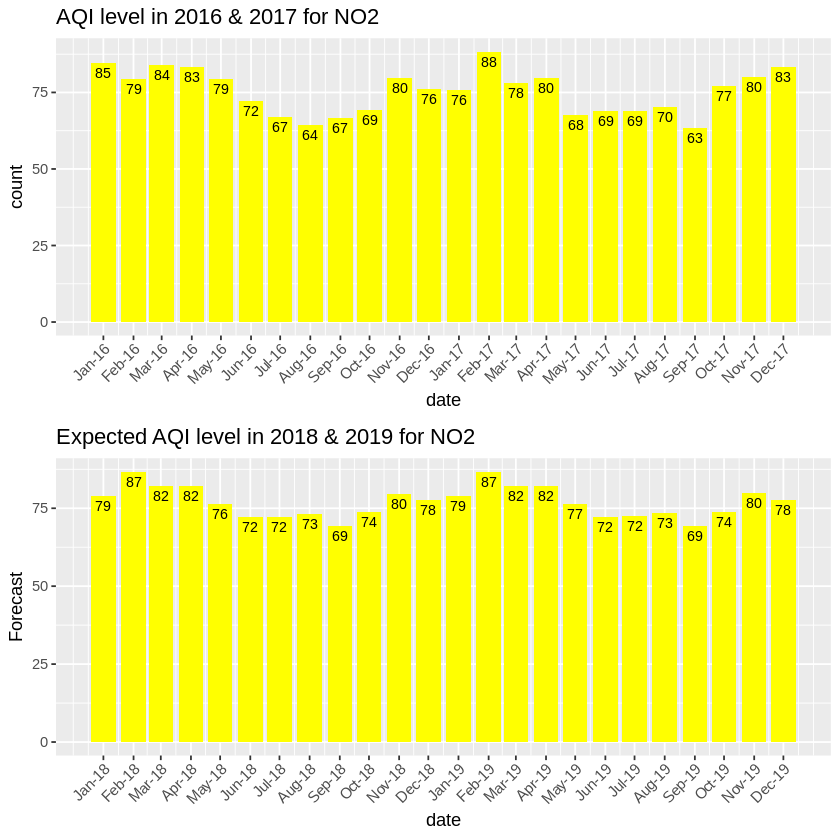

In [105]:
ets_forecast_df$colour<- cut(ets_forecast_df$Forecast, breaks = c(-Inf,50,100,150,Inf),
         labels = c("green", "yellow", "orange","red"))

after_pred<-ggplot(ets_forecast_df,aes(date,Forecast,fill=colour))+geom_bar(stat="identity",position="dodge")+
geom_text(aes(label = round(Forecast)), position = position_dodge(width = 1),
            vjust = 1.5, size = 3) +
scale_x_date(breaks = seq(as.Date("2018-01-01"), as.Date("2019-12-01"), by="1 month"), date_labels = "%b-%y")+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")+scale_fill_identity()+
ggtitle("Expected AQI level in 2018 & 2019 for NO2")

count_=((pol_flow_final$count[217:240]/1000)/0.053)*100
last_two_year<-data.frame("date"=pol_flow_final$date[217:240],"count"=count_)
last_two_year$colour<- cut(last_two_year$count, breaks = c(-Inf,50,100,150,Inf),
         labels = c("green", "yellow", "orange","red"))

before_pred<-ggplot(last_two_year,aes(date,count,fill=colour))+geom_bar(stat="identity",position="dodge")+
geom_text(aes(label = round(count)), position = position_dodge(width = 1),
            vjust = 1.5, size = 3) +
scale_x_date(breaks = seq(as.Date("2016-01-01"), as.Date("2017-12-01"), by="1 month"), date_labels = "%b-%y")+
theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position="none")+scale_fill_identity()+
ggtitle("AQI level in 2016 & 2017 for NO2")
grid.arrange(before_pred,after_pred,nrow=2)